# Coefficient Estimation for NEWT

The optimal model involves eight seasonality coefficients and a baseline air temperature sensitivity, a total of nine terms.  We don't need to estimate anything for the relationship between seasonal temperature and sensitivity on a given day, since a global GAM does that.  So we have nine coefficients to estimate.

However, those nine coefficients are correlated, which raises problems for uncertainty analysis and, in general, suggests inefficiency.  So the first thing we're going to do is principle component analysis on the coefficients.

In [1]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
import os
from sklearn.decomposition import PCA
import pygam  # https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html
from pygam import LinearGAM, s, te, l, f
from NEWT import Watershed, kfold, perf_summary, statics, analysis, engines
from NEXT.coef_est import build_training_data
import NEXT.data as ndata
import NEWT
import NEXT
from math import ceil
anomweights = np.array([0.132, 0.401, 0.162, 0.119, 0.056, 0.13 ])
bp = "/scratch/dphilippus/notebooks/next_validation/"

ERROR 1: PROJ: proj_create_from_database: Open of /u/wy/ch/dphilippus/.conda/envs/next/share/proj failed


In [2]:
# sillymod: use one generic model.  Otherwise, fit each model to itself.
def dummy_modbuilder(data, sillymod):
    data = data.groupby("date")[["temperature", "tmax", "vp"]].mean().assign(date = lambda x: x.index)
    def runner(ws):
        try:
            if sillymod:
                return Watershed.from_data(data).run_series(ws)
            else:
                return Watershed.from_data(ws).run_series(ws)
        except Exception as e:
            print(e)
    return runner

In [3]:
data = pd.read_csv(bp + "DevDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"])
data = data[(data["temperature"] > -0.5) & (data["temperature"] < 40)]
data

,id,date,temperature,prcp,srad,swe,tmax,tmin,vp,day,...,asp_north,asp_east,lat,lon,year,canopy,flowdir,frozen,cold_prcp,ws_canopy
0,13011820,2020-03-31,0.100000,17.110126,248.76216,NaN,1.795443,NaN,444.26370,91,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,False,0.000000,27.182915
1,13011820,2020-04-01,0.100000,7.202532,403.38873,NaN,0.030759,NaN,270.94354,92,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,False,0.000000,27.182915
2,13011820,2020-04-02,0.100000,2.167848,600.86993,NaN,-3.442405,NaN,132.77936,93,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,True,2.167848,27.182915
3,13011820,2020-04-03,0.100000,2.987468,509.44165,NaN,-2.238481,NaN,138.35303,94,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,True,2.987468,27.182915
4,13011820,2020-04-04,0.100000,6.021518,465.97583,NaN,3.509114,NaN,284.43704,95,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,False,0.000000,27.182915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987895,03047000,2022-12-27,0.540625,0.000000,268.23563,NaN,-2.151775,NaN,207.79785,361,...,0.004324,0.003170,40.458889,-79.449444,2022,29.154762,12.102172,True,0.000000,55.414196
2987896,03047000,2022-12-28,0.407292,0.000000,279.93356,NaN,5.509683,NaN,310.02664,362,...,0.004324,0.003170,40.458889,-79.449444,2022,29.154762,12.102172,False,0.000000,55.414196
2987897,03047000,2022-12-29,0.428125,0.000000,290.53482,NaN,13.100331,NaN,354.31638,363,...,0.004324,0.003170,40.458889,-79.449444,2022,29.154762,12.102172,False,0.000000,55.414196
2987898,03047000,2022-12-30,0.661458,0.000000,285.53320,NaN,17.568270,NaN,512.88240,364,...,0.004324,0.003170,40.458889,-79.449444,2022,29.154762,12.102172,False,0.000000,55.414196


In [4]:
data.drop(columns="date").describe()

,temperature,prcp,srad,swe,tmax,tmin,vp,day,water,developed,...,slope,asp_north,asp_east,lat,lon,year,canopy,flowdir,cold_prcp,ws_canopy
count,2.987900e+06,2.987900e+06,2.987900e+06,578400.000000,2.987900e+06,1.433446e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,...,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.986986e+06
mean,1.304480e+01,3.425176e+00,3.273382e+02,17.926649,1.688383e+01,5.062516e+00,9.831255e+02,1.872229e+02,1.268352e-02,1.478107e-01,...,1.884932e-03,7.355827e-03,-1.552842e-03,3.992888e+01,-9.565336e+01,2.016161e+03,3.147648e+01,1.888851e+02,1.473491e-01,4.173630e+01
std,7.778464e+00,8.017643e+00,1.310696e+02,49.761395,1.065262e+01,9.425389e+00,6.475989e+02,1.040032e+02,2.060045e-02,2.192455e-01,...,2.532902e-03,1.024769e-02,1.524831e-02,4.613372e+00,1.749465e+01,4.168676e+00,2.808762e+01,9.836393e+01,1.352327e+00,2.300219e+01
min,-4.989583e-01,0.000000e+00,1.599158e+01,0.000000,-2.844553e+01,-3.810106e+01,1.937390e+01,1.000000e+00,0.000000e+00,0.000000e+00,...,4.762368e-05,-1.538242e-02,-2.824883e-01,2.697500e+01,-1.243930e+02,2.004000e+03,0.000000e+00,5.787924e-01,0.000000e+00,4.107644e-02
25%,6.691667e+00,0.000000e+00,2.272068e+02,0.000000,8.669371e+00,-1.216429e+00,5.072167e+02,9.900000e+01,1.829815e-03,1.931167e-02,...,4.481627e-04,3.460877e-03,-2.773193e-03,3.731277e+01,-1.120107e+02,2.013000e+03,4.000000e+00,1.047749e+02,0.000000e+00,2.231672e+01
50%,1.255729e+01,0.000000e+00,3.281181e+02,0.000000,1.786824e+01,5.120216e+00,7.729694e+02,1.890000e+02,5.872330e-03,5.986721e-02,...,9.428893e-04,5.018477e-03,2.168743e-03,4.005460e+01,-8.861419e+01,2.017000e+03,2.404255e+01,1.992379e+02,0.000000e+00,4.210295e+01
75%,1.918229e+01,3.160186e+00,4.291651e+02,7.820107,2.572708e+01,1.199073e+01,1.328157e+03,2.770000e+02,1.551254e-02,1.489284e-01,...,2.337958e-03,8.388438e-03,3.922721e-03,4.325386e+01,-8.047256e+01,2.020000e+03,5.741737e+01,2.747320e+02,0.000000e+00,6.113925e+01
max,3.999688e+01,2.717640e+02,8.285261e+02,750.342160,4.495986e+01,2.819078e+01,3.693103e+03,3.650000e+02,2.316803e-01,9.849686e-01,...,3.008171e-02,2.041745e-01,1.524249e-02,4.899881e+01,-6.780389e+01,2.022000e+03,9.486487e+01,3.586496e+02,8.861503e+01,8.766909e+01


## Add Reach Buffer Data 

For each site, we want 1-km-upstream, 15-m-buffer canopy cover and mean direction.  Conveniently, flow direction maps exactly onto slope aspect of the river itself, since by definition it flows precisely downhill.  Runtime depends on period of record, but is currently averaging 15 seconds per site (suggesting ~4 hours for all of them).

## A Silly Kfold Test

First we need to test the cross-validation setup, so we have a dummy model to test it with.  One option is to use a model that's just trained on everything.  The other option is to use a model that's trained on each watershed to predict itself.

## Prepare Coefficients

Since the kfold testing seems to be working, let's prepare model coefficients.  To recap, we need to provide seasonality coefficients, tmax and vp sensitivities, and tmax and vp dailies (for static/spin-up).  We can also set up dynamic and yearly modification engines, and will eventually separate estimators into static (at start) and climate/dynamic (through a climate modification engine), but that can come later.

In [5]:
def make_coefficients(grp):
    if len(grp["day"].unique()) < 181:
        return None
    anomilized = NEWT.watershed.anomilize(grp).sort_values("date")[["date", "st_anom", "at_anom"]]  # st_anom, at_anom
    ssn = rts.ThreeSine.from_data(grp[["day", "temperature"]]).to_df().drop(columns=["RMSE", "R2"])
    for i in range(6):
        anomilized[f"delta{i}"] = anomilized["at_anom"].shift(i)
    anomilized = anomilized.dropna()
    X = anomilized.loc[:, "delta0":"delta5"]
    y = anomilized["st_anom"]
    prd = X @ anomweights
    ssn["sensitivity"] = y.abs().mean() / prd.abs().mean()
    return ssn

In [6]:
coefs = data.groupby("id").apply(make_coefficients, include_groups=False).droplevel(1)
coefs.describe()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,sensitivity
count,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000
mean,12.740453,8.882257,326.754615,66.920738,154.070575,217.706840,0.739229,1.398364,0.610154
std,3.993507,2.723280,15.606734,32.471663,21.642059,17.322166,0.955179,0.920352,0.166154
min,3.085846,0.182583,300.000000,1.000000,120.000000,200.000000,-2.585014,-2.453322,0.072260
25%,9.907242,7.209934,317.000000,33.000000,135.000000,200.000000,0.062890,0.828810,0.504472
50%,12.520833,9.357408,327.000000,84.000000,156.000000,212.000000,0.471416,1.409035,0.612575
75%,14.876002,10.884484,333.000000,90.000000,177.000000,238.000000,1.199086,1.924694,0.708648
max,30.100749,15.907383,365.000000,110.000000,180.000000,240.000000,4.922727,4.801733,1.641213


When seasonality coefficients are near zero, dates are noisy, and we don't want that messing with our model, so we set days to their mean when the corresponding seasonal coefficient is low - "low" being below the 25th percentiles, which are 0.06 C for SpringSummer and 0.8 C for FallWinter.

In [7]:
means = coefs.mean()

In [8]:
coefs["SpringSummer"].quantile(0.25)

0.06289025380961942

In [9]:
coefs.loc[coefs["FallWinter"] < 0.8, "FallDay"] = means["FallDay"]
coefs.loc[coefs["FallWinter"] < 0.8, "WinterDay"] = means["WinterDay"]
coefs.loc[coefs["SpringSummer"] < 0.06, "SpringDay"] = means["SpringDay"]
coefs.loc[coefs["SpringSummer"] < 0.06, "SummerDay"] = means["SummerDay"]
coefs.describe()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,sensitivity
count,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000
mean,12.740453,8.882257,323.981825,70.204823,150.549655,218.019081,0.739229,1.398364,0.610154
std,3.993507,2.723280,10.543154,24.986690,17.370288,14.802704,0.955179,0.920352,0.166154
min,3.085846,0.182583,300.000000,1.000000,120.000000,200.000000,-2.585014,-2.453322,0.072260
25%,9.907242,7.209934,318.000000,66.920738,138.000000,201.000000,0.062890,0.828810,0.504472
50%,12.520833,9.357408,326.754615,76.000000,154.070575,217.706840,0.471416,1.409035,0.612575
75%,14.876002,10.884484,330.000000,89.000000,159.000000,234.000000,1.199086,1.924694,0.708648
max,30.100749,15.907383,365.000000,110.000000,180.000000,240.000000,4.922727,4.801733,1.641213


In [10]:
coefs.corr()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,sensitivity
Intercept,1.000000,0.131512,0.275747,0.354293,0.231899,0.069154,-0.470499,0.084123,0.492254
Amplitude,0.131512,1.000000,-0.197296,0.102701,-0.058135,-0.292471,-0.231572,0.475005,0.324736
FallDay,0.275747,-0.197296,1.000000,0.125064,0.138823,0.199899,-0.130959,-0.160312,0.066890
WinterDay,0.354293,0.102701,0.125064,1.000000,0.351654,-0.107846,-0.320361,0.023822,0.391305
SpringDay,0.231899,-0.058135,0.138823,0.351654,1.000000,0.224419,-0.124357,-0.067588,0.179419
SummerDay,0.069154,-0.292471,0.199899,-0.107846,0.224419,1.000000,0.161994,-0.465965,-0.074882
SpringSummer,-0.470499,-0.231572,-0.130959,-0.320361,-0.124357,0.161994,1.000000,-0.142382,-0.276136
FallWinter,0.084123,0.475005,-0.160312,0.023822,-0.067588,-0.465965,-0.142382,1.000000,0.154127
sensitivity,0.492254,0.324736,0.066890,0.391305,0.179419,-0.074882,-0.276136,0.154127,1.000000


## Feature Weights

For feature-weighted PCA, we want to compute the global R2 penalty (in calibrated models) of fixing each coefficient to its mean.

In [11]:
means = coefs.mean()

In [12]:
def site_predict(data):
    c = data.head(1)  # coefficient row
    model = NEWT.Watershed(rts.ThreeSine.from_coefs(c),
                           c["sensitivity"].iloc[0],
                           data.groupby("day", as_index=False)["tmax"].mean().rename(columns={"tmax": "mean_tmax"}))
    prd = model.run_series(data)[["date", "temp.mod"]]
    return data[["date", "temperature"]].merge(prd, on="date")

def predict(coef_tab, data):
    # Predict timeseries for the given data and coefficient table.
    comb = data.merge(coef_tab, on="id").dropna()
    return comb.groupby("id").apply(site_predict, include_groups=False)

def drop_impact(feature, base_r2, coef_tab, data):
    coef_tab = coef_tab.copy()
    coef_tab[feature] = means[feature]
    prd = predict(coef_tab, data)
    r2 = prd["temperature"].corr(prd["temp.mod"])**2
    return {
        "new_r2": r2,
        "penalty": base_r2 - r2
    }

In [13]:
base_prd = predict(coefs, data)

In [14]:
base_r2 = base_prd["temperature"].corr(base_prd["temp.mod"])**2
base_r2

0.9475340984009903

In [15]:
weights = pd.DataFrame([
    {"feature": feature} | drop_impact(feature, base_r2, coefs, data)
    for feature in coefs.columns
])

In [16]:
weights

,feature,new_r2,penalty
0,Intercept,0.670743,0.276792
1,Amplitude,0.886547,0.060987
2,FallDay,0.942295,0.005239
3,WinterDay,0.943740,0.003794
4,SpringDay,0.943074,0.004460
5,SummerDay,0.946042,0.001492
6,SpringSummer,0.945280,0.002254
7,FallWinter,0.943915,0.003619
8,sensitivity,0.944522,0.003012


With fixed low-anomaly dates, most features become extremely unimportant.

## PCA

We are going to try scaling to the feature importances, above.

In [17]:
pc_weights = weights.set_index("feature")["penalty"]
pc_weights

feature
Intercept       0.276792
Amplitude       0.060987
FallDay         0.005239
WinterDay       0.003794
SpringDay       0.004460
SummerDay       0.001492
SpringSummer    0.002254
FallWinter      0.003619
sensitivity     0.003012
Name: penalty, dtype: float64

In [18]:
offset = coefs.mean()
scale = coefs.std() / pc_weights

In [61]:
offset.to_numpy()

array([ 12.74045259,   8.88225679, 323.98182474,  70.20482269,
       150.54965511, 218.01908066,   0.73922948,   1.3983637 ,
         0.61015365])

In [19]:
scale.to_numpy()

array([  14.42784611,   44.65373443, 2012.31658041, 6585.14924421,
       3894.52975922, 9921.9668602 ,  423.79953993,  254.32678676,
         55.16868856])

In [20]:
co_norm = (coefs - offset) / scale
co_norm

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,sensitivity
id,,,,,,,,,
01010000,-0.312793,0.062307,-0.000488,-0.006485,-0.007844,0.001812,0.002951,0.007359,0.001475
01011000,-0.290604,0.063902,-0.000985,-0.006561,-0.007844,-0.001413,0.004304,0.005302,-0.000826
01018035,-0.254058,0.069994,-0.001482,-0.006409,-0.007844,-0.001211,0.002593,0.004603,-0.000216
01038000,-0.129557,0.079524,-0.002476,-0.006561,0.004738,-0.001816,0.000378,0.002232,-0.000142
010642505,-0.312414,0.008297,-0.001482,-0.006713,-0.007331,0.001510,0.002424,-0.001446,-0.002232
...,...,...,...,...,...,...,...,...,...
385903107210800,-0.386569,0.008431,-0.011918,0.002550,-0.001939,-0.001715,0.003172,0.000045,0.002204
394220106431500,-0.400298,-0.034151,0.000009,0.002095,0.001399,0.001913,0.004919,0.002283,-0.001963
402114105350101,-0.581387,-0.034560,-0.011421,0.002702,0.000629,0.001913,0.004143,-0.001628,-0.000892


There are some nontrivial cross-correlations, so let's see what the principal component axes look like.

In [21]:
pca = PCA()
fit = pca.fit(co_norm)
evr = fit.explained_variance_ratio_
print(evr)
print(np.cumsum(evr))

[9.53563232e-01 4.54765917e-02 3.08459024e-04 2.58636692e-04
 1.35093314e-04 1.26620539e-04 6.91489724e-05 4.47351965e-05
 1.74830130e-05]
[0.95356323 0.99903982 0.99934828 0.99960692 0.99974201 0.99986863
 0.99993778 0.99998252 1.        ]


Of the 9 coefficients, we capture 96% of the variance with 8 of them, 92% with 7, 86% with 6, etc.  But that's not the point: we're looking to predict uncorrelated variables, not compress the space.

With feature weighting, the first PC explains 95% of feature importance and the second brings it to over 99%. Same thing with fixed low-anomaly dates.

<Axes: >

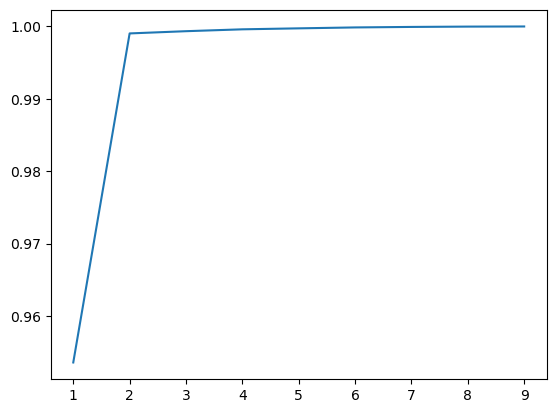

In [22]:
sns.lineplot(x=np.arange(1, len(evr)+1), y=np.cumsum(evr))

In [23]:
pcax = pd.DataFrame(fit.components_,
            columns=coefs.columns)  # shape: components x features. So a row is a PC and a column is a feature.
pcax

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,sensitivity
0,0.999483,0.030411,0.005189,0.004861,0.003727,0.000362,-0.003839,0.001140,0.005373
1,0.030396,-0.998769,0.020718,-0.003410,0.006748,0.007542,0.006270,-0.028060,-0.012920
2,-0.008054,0.022813,0.887917,0.216407,0.380027,0.054877,-0.036858,-0.114985,0.046633
3,0.003278,0.007010,0.446467,-0.432168,-0.770817,-0.014042,0.031691,0.016279,-0.134952
4,0.003868,0.020290,-0.042579,-0.749394,0.435494,0.192204,0.136719,-0.352755,-0.257765
5,-0.000181,0.020385,-0.092215,0.280032,-0.251328,0.126158,0.000735,-0.906050,0.112488
6,-0.002823,-0.009916,0.022681,-0.281863,0.015043,0.040439,0.198416,0.028299,0.936964
7,0.003242,0.006375,0.016499,0.200829,-0.038180,0.119899,0.957242,0.070060,-0.149296
8,-0.001140,-0.000484,-0.026672,0.081087,-0.082801,0.963257,-0.152343,0.186152,0.011424


So what's actually going into this stuff?  From most important to least:

0. Distributed across pretty much everything except Fall, Spring, and Summer days.
1. Heavy on the three days omitted before, plus some weight on Intercept, Amplitude, and FallWinter.
2. Heavy on SpringDay and sensitivity with some Amplitude.
3. Heavy on SpringSummer and Summer, Spring and Fall days
4. SummerDay, SpringSummer, and sensitivity
5. FallWinter, with a little Fall and Winter days
6. Amplitude and FallDay
7. WinterDay, SpringDay, and Intercept
8. Intercept, SummerDay, and FallWinter

Note that all components and all features have roughly equal total absolute weights, just distributed differently.  Total non-absolute weights are quite variable.

With date-only weighting, the first PC is basically Intercept, the second Amplitude, and the last Sensitivity. The middle block are smeared out across dates and seasonal anomalies. Note that dropping the last PC would result in effectively constant sensitivity, which is not ideal.

<Axes: >

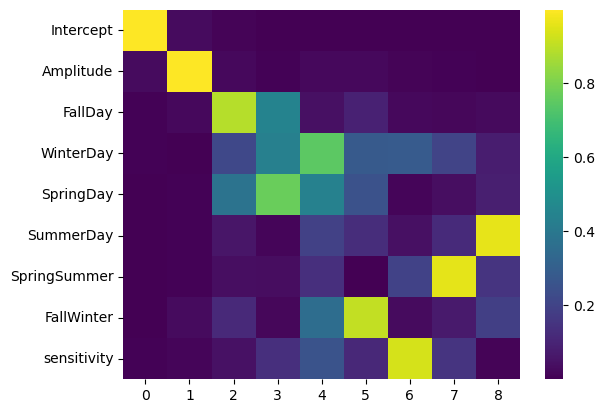

In [24]:
sns.heatmap(pcax.T.abs(), cmap="viridis")

As a sanity check, coefficients x t(PCA) should give us 9 uncorrelated variables.  It works!  And we invert it by multiplying by (non-transposed) PCA components.

In [25]:
comps = co_norm @ np.transpose(fit.components_)
comps.columns = [f"pca{x}" for x in range(9)]
comps.corr()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8
pca0,1.000000e+00,-2.020228e-16,-1.515923e-16,2.159483e-17,1.481807e-16,1.549084e-16,-1.732986e-16,-2.040372e-16,-2.612445e-16
pca1,-2.020228e-16,1.000000e+00,3.472254e-17,-1.151665e-15,1.118822e-15,1.828123e-16,8.536934e-16,-1.372793e-15,3.212777e-16
pca2,-1.515923e-16,3.472254e-17,1.000000e+00,-6.488935e-17,1.464817e-16,-2.983200e-17,1.468547e-16,-6.816952e-17,-5.234016e-16
pca3,2.159483e-17,-1.151665e-15,-6.488935e-17,1.000000e+00,4.548596e-16,-3.259152e-16,5.856516e-16,-3.262020e-17,-1.531816e-15
pca4,1.481807e-16,1.118822e-15,1.464817e-16,4.548596e-16,1.000000e+00,3.851320e-18,-2.309674e-17,-1.335647e-16,5.698187e-16
pca5,1.549084e-16,1.828123e-16,-2.983200e-17,-3.259152e-16,3.851320e-18,1.000000e+00,-6.038264e-16,-2.764544e-16,6.850483e-16
pca6,-1.732986e-16,8.536934e-16,1.468547e-16,5.856516e-16,-2.309674e-17,-6.038264e-16,1.000000e+00,-1.913960e-16,-2.185804e-16
pca7,-2.040372e-16,-1.372793e-15,-6.816952e-17,-3.262020e-17,-1.335647e-16,-2.764544e-16,-1.913960e-16,1.000000e+00,-1.330382e-18
pca8,-2.612445e-16,3.212777e-16,-5.234016e-16,-1.531816e-15,5.698187e-16,6.850483e-16,-2.185804e-16,-1.330382e-18,1.000000e+00


In [26]:
fit.components_

array([[ 9.99482701e-01,  3.04114428e-02,  5.18896366e-03,
         4.86075504e-03,  3.72667184e-03,  3.61687834e-04,
        -3.83874824e-03,  1.13986046e-03,  5.37298110e-03],
       [ 3.03963926e-02, -9.98768807e-01,  2.07181942e-02,
        -3.41009351e-03,  6.74797899e-03,  7.54246632e-03,
         6.26977656e-03, -2.80604082e-02, -1.29203676e-02],
       [-8.05426117e-03,  2.28125644e-02,  8.87916707e-01,
         2.16406937e-01,  3.80027159e-01,  5.48766005e-02,
        -3.68581099e-02, -1.14984678e-01,  4.66325565e-02],
       [ 3.27831929e-03,  7.01015219e-03,  4.46467373e-01,
        -4.32167844e-01, -7.70817371e-01, -1.40424793e-02,
         3.16908240e-02,  1.62793905e-02, -1.34951892e-01],
       [ 3.86793301e-03,  2.02903702e-02, -4.25788472e-02,
        -7.49394444e-01,  4.35493559e-01,  1.92204451e-01,
         1.36718775e-01, -3.52755204e-01, -2.57765205e-01],
       [-1.80515119e-04,  2.03850886e-02, -9.22150546e-02,
         2.80032083e-01, -2.51328385e-01,  1.261582

In [27]:
coefs_rc = comps @ fit.components_
coefs_rc.columns = coefs.columns
coefs_rc = coefs_rc * scale + offset
coefs_rc - coefs

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,sensitivity
id,,,,,,,,,
01010000,5.329071e-15,-1.776357e-15,0.000000e+00,9.237056e-14,4.263256e-14,-2.842171e-14,-6.661338e-16,0.000000e+00,4.440892e-16
01011000,3.552714e-15,0.000000e+00,0.000000e+00,1.136868e-13,2.842171e-14,0.000000e+00,-1.332268e-15,0.000000e+00,4.440892e-16
01018035,1.776357e-15,-1.776357e-15,0.000000e+00,1.136868e-13,4.263256e-14,0.000000e+00,-1.332268e-15,0.000000e+00,4.440892e-16
01038000,1.776357e-15,-1.776357e-15,5.684342e-14,9.947598e-14,-2.842171e-14,5.684342e-14,-1.998401e-15,6.661338e-16,2.220446e-16
010642505,5.329071e-15,0.000000e+00,0.000000e+00,7.815970e-14,2.842171e-14,0.000000e+00,-1.332268e-15,2.220446e-16,3.330669e-16
...,...,...,...,...,...,...,...,...,...
385903107210800,4.440892e-15,0.000000e+00,5.684342e-14,-2.842171e-14,0.000000e+00,5.684342e-14,-1.776357e-15,-4.440892e-16,1.110223e-16
394220106431500,4.440892e-15,8.881784e-16,0.000000e+00,-4.263256e-14,0.000000e+00,-2.842171e-14,-4.440892e-16,0.000000e+00,0.000000e+00
402114105350101,7.105427e-15,8.881784e-16,5.684342e-14,-5.684342e-14,0.000000e+00,0.000000e+00,-1.332268e-15,-3.330669e-16,1.110223e-16


# Model

We'll use a GAM.  This lets us test a broad range of relationships while keeping it quick and interpretable, and has precedent in the literature (PNW from Siegel et al at NOAA Northwestern Fisheries).

## Generalized Code

In [28]:
preds = NEXT.coef_est.preprocess(data).drop(columns=["level_1_x", "level_1_y", "date", "day"])
preds.columns

Index(['id', 'tmax', 'prcp', 'srad', 'vp', 'area', 'elev_min', 'elev', 'slope',
       'forest', 'wetland', 'developed', 'ice_snow', 'water', 'canopy',
       'ws_canopy', 'lat', 'lon', 'frozen', 'cold_prcp', 'prcp_sd', 'srad_sd',
       'vp_sd', 'prcp_phi', 'prcp_index', 'tmax_phi', 'tmax_index'],
      dtype='object')

In [29]:
mdata = comps.merge(preds, on="id", how="left")

In [30]:
X = mdata.iloc[:, 10:]
allvar = X.columns
allvref = allvar
Y = mdata.loc[:, "pca0":"pca8"]

In [31]:
allvar

Index(['tmax', 'prcp', 'srad', 'vp', 'area', 'elev_min', 'elev', 'slope',
       'forest', 'wetland', 'developed', 'ice_snow', 'water', 'canopy',
       'ws_canopy', 'lat', 'lon', 'frozen', 'cold_prcp', 'prcp_sd', 'srad_sd',
       'vp_sd', 'prcp_phi', 'prcp_index', 'tmax_phi', 'tmax_index'],
      dtype='object')

In [32]:
# Reference linear model
Xnp = np.concatenate((np.ones((len(X), 1)), X.to_numpy()), axis=1)
lfit = np.linalg.lstsq(Xnp, Y, rcond=None)[0]
prd = Xnp @ lfit
refwt = pd.concat([
    pd.DataFrame({"R2": np.corrcoef(Y.iloc[:, i], prd[:, i])[0, 1]**2}, index=[Y.columns[i]])
    for i in range(len(Y.columns))
])
refwt

,R2
pca0,0.875747
pca1,0.567369
pca2,0.182429
pca3,0.215236
pca4,0.207703
pca5,0.341131
pca6,0.175693
pca7,0.268570
pca8,0.087371


In [33]:
varname = {
    'intercept': "Mean Air Temperature (C)",
    'prcp': "Mean Precipitation (mm/day)",
    'cold_prcp': "Mean Subfreezing Precip (mm/day)",
    'frozen': "Proportion of Days Below Freezing",
    'srad': "Mean Solar Radiation (W/m2)",
    'water': "Water Land Cover Fraction",
    'developed': "Developed Land Cover Fraction",
    'barren': "Barren Land Cover Fraction",
    'forest': "Forest Land Cover Fraction",
    'shrubland': "Shrubland Land Cover Fraction",
    'herbaceous': "Herbaceous Land Cover Fraction",
    'cultivated': "Cultivated Land Cover Fraction",
    'wetland': "Wetland Land Cover Fraction",
    'ice_snow': "Ice/Snow Land Cover Fraction",
    'canopy': "Last-km Riparian Canopy Cover (%)",
    'flowdir': "Mean Last-km Flow Direction (deg)", 
    'area': "Watershed Area (m2)",
    'elev': "Mean Elevation (m)",
    'elev_min': "Min Elevation (m)",
    'slope': "Watershed Mean Slope (m/m)",
    'asp_north': "Slope Aspect Mean North Component",
    'asp_east': "Slope Aspect Mean East Component",
    'lat': "Latitude (deg N)",
    'lon': "Longitude (deg E)",
    'prcp_sd': "Std Dev Precipitation (mm/day)",
    'srad_sd': "Std Dev Solar Radiation (W/m2)",
    'vp': 'Mean Vapor Pressure (Pa)',
    'vp_sd': "Std Dev Vapor Pressure (Pa)",
    'prcp_phi': "Mean Date of Precip (Julian day)",
    'prcp_index': "Precip Seasonality Index",
    'tmax': 'Mean Daily Max Air Temp (C)',
    'tmax_phi': 'Mean Date of Air Temp (Julian day)',
    'tmax_index': 'Air Temp Seasonality Index',
    "Intercept": "3S Intercept (C)",
    "Amplitude": "3S Amplitude (C)",
    "SpringSummer": "3S Spring/Summer Coef. (C)",
    "FallWinter": "3S Autumn/Winter Coef. (C)",
    "SpringDay": "3S Spring Date (Julian day)",
    "SummerDay": "3S Summer Date (Julian day)",
    "FallDay": "3S Autumn Date (Julian day)",
    "WinterDay": "3S Winter Date (Julian day)",
    "sensitivity": "Air Temp. Anomaly Sensitivity (C/C)",
    "ws_canopy": "Watershed Mean Canopy Cover (%)"
}
rename = lambda vrs: [varname[v] for v in vrs]

After PCA, the best-variable linear performance is much worse, at 0.59.  We'll see how the GAM does.

With the rescaled round 1 (dates scaled only), best-variable fit is 0.87, with 0.56 for the next and declining from there.

In [34]:
eqmk = lambda N: sum([s(i) for i in range(1, N)], start=s(0))
without = lambda l, v: [i for i in l if i != v]

def gam_gcv(X, Y, eq, lam):
    return LinearGAM(eq, lam=lam).fit(X, Y).statistics_["GCV"]
    # return -LinearGAM(eq, lam=lam).fit(X, Y).statistics_["pseudo_r2"]['explained_deviance']

def tune_lam(X, Y, lams, counter=0, tolerance=0.001, maxdepth=100, debug=False):
    # Lams: 3 lambda candidates (low, mid, high)
    # Tolerance: minimum change in GCV to proceed.
    print("|", end="")
    eq = eqmk(len(X.columns))
    (l, m, r) = lams
    left = gam_gcv(X, Y, eq, l)
    mid = gam_gcv(X, Y, eq, m)
    right = gam_gcv(X, Y, eq, r)
    if debug:
        print(f"{l} = {left} | {m} = {mid} | {r} = {right}")
    # First, we compute the improvement, the new set, and the reference
    # option.  After that, we'll decide whether to keep iterating.
    # Spacing is computed by powers of 10.
    if (delta := mid - left) > 0:  # low is good
        ref = l
        nl = (l/10, l, l * (m/l)**(1/2))
    elif (delta := mid - right) > 0:  # high is good
        ref = r
        nl = (m * (r/m)**(1/2), r, r*10)
    else:
        delta = mid - min([left, right])
        ref = m
        nl = (m * (l/m)**(1/2), m, m * (r/m)**(1/2))
    # Now we decide whether to proceed or return.
    if delta > tolerance and counter < maxdepth:
        return tune_lam(X, Y, nl, counter+1, tolerance, maxdepth, debug)
    else:
        return ref

def tune_gcv(varset, lam, gcv, X, Y, tolerance=0, debug=False):
    # Iteratively tune a GAM to optimize GCV.  In each round, we optimize lambda and drop one variable.
    # Proceed only if we reduce GCV.  Otherwise, return the current arrangement.
    varset = varset.copy()
    if gcv is None:
        gcv = gam_gcv(X[varset], Y, eqmk(len(varset)), lam)
    # First pass: tune lambda.
    lam = tune_lam(X[varset], Y, (lam/3, lam, lam*3))
    # Next: drop one variable.
    best_gcv = gcv
    best_var = None
    if debug:
        print(gcv)
    for v in varset:
        new_vars = without(varset, v)
        new_gcv = gam_gcv(X[new_vars], Y, eqmk(len(new_vars)), lam)
        if debug:
            print(v, new_gcv)
        if new_gcv < best_gcv:
            best_gcv = new_gcv
            best_var = v
    if best_var is None or gcv - best_gcv < tolerance:
        return (varset, lam, gcv)
    else:
        varset.remove(best_var)
        print(f"Lambda: {lam:.2f} | Dropped: {best_var} | GCV: {best_gcv:.4f}")
        return tune_gcv(varset, lam, best_gcv, X, Y, tolerance)

def pca_pdps(gams, savebase, Npca=9, pca=fit.components_, scale=scale, offset=offset, cols=coefs.columns,
            rtn=False, hgt=3):
    """
    Generate PDPs, then invert PCA so they correspond to actual coefficients.
    Save resulting PDPs by y and by x in savebase.
    GAMs should be a list of tuples: (gam, x names, simple x names, PCA index)
    GAMs must be in order of PCA.
    
    How does the math work?
    A given PC corresponds to a variety of coefficients.
    If we multiply one X-PC (single column) by the corresponding PCA row,
    we get the contribution of that X, to that PC, distributed across all relevant Y.
    Now, if we take every PC-PDP for that X (with zeroes where NA) and multiply
    by the PCAs, we get the total contribution of that X to every Y.
    That makes a data frame of nX * nY.
    If we concatenate those together, we can group them by X or Y, and generate plots accordingly.
    
    To do that, we first have to extract X/PC pairs from all the PDPs.
    
    This is modified from pdps_by_x.
    
    If rtn is True, it will just return the first plot, for debugging purposes.
    """
    xes = {}
    for (gam, xns, sxns, index) in gams:
        terms = [t for t in gam.terms if not t.isintercept]
        for (i, sxn) in enumerate(sxns):
            if not sxn in xes:
                xes[sxn] = {"xlab": xns[i], "ys": []}
            gxg = gam.generate_X_grid(term=i, n=100)
            X = gxg[:, terms[i].feature]
            pdep = gam.partial_dependence(term=i, X=gxg)
            xes[sxn]["ys"].append((
                index, X, pdep
            ))
    # Now we have a dictionary {simple x name: {"xlab", "ys": [(index, X, Y)]}}.  Hopefully the X are always the same?
    results = []
    for (sxn, vals) in xes.items():
        xlab = vals["xlab"]
        yinfo = vals["ys"]
        ref_x = yinfo[0][1]
        Y = np.zeros((len(ref_x), Npca))
        for yset in yinfo:
            if not (yset[1] == ref_x).all():
                raise ValueError(f"Mismatched X grids!  {sxn}, {yset[0]}")
            Y[:, yset[0]] = yset[2]
        # Now we have an X column (ref_x) and a Y matrix.
        # Don't add offset, because we just want partial dependency.
        Y_adj = pd.DataFrame(Y @ pca, columns=cols) * scale
        df = pd.concat([pd.Series(ref_x, name="X"), Y_adj], axis=1)
        df["X_name"] = xlab
        df["sxn"] = sxn
        results.append(df)
    results = pd.concat(results)
    # Now results is a data frame with X, [ys...], X_name, sxn
    # Plots by X variable.
    for sxn, df in results.groupby("sxn"):
        xname = df["X_name"].iloc[0]
        ynames = df.columns[1:]
        fig = sns.relplot(df.melt(id_vars=["X", "X_name", "sxn"]), x="X", y="value",
                          col="variable", col_wrap=3, facet_kws={"sharey": False},
                          kind="line", height=hgt)
        fig.set_xlabels(xname)
        for ax in fig.axes:
            vn = varname[ax.title.get_text().split(" = ")[1]]
            ax.set_ylabel(vn)
            ax.set_title("")
        if rtn:
            return fig
        fig.savefig(savebase + f"X_{sxn}.png", dpi=1000)
        plt.close()
    # Plots by Y variable.
    for syn, df in results.melt(id_vars=["X", "X_name", "sxn"]).groupby("variable"):
        yname = varname[syn]
        # N = len(df["X_name"].unique())
        # wrap = int(np.sqrt(N)) + 1
        wrap = 4
        fig = sns.relplot(df, x="X", y="value", col="X_name", col_wrap=wrap,
                          facet_kws={"sharex": False}, kind="line", height=hgt)
        fig.set_ylabels(yname)
        for ax in fig.axes:
            vn = ax.title.get_text().split(" = ")[1]
            ax.set_xlabel(vn)
            ax.set_title("")
        if rtn:
            return fig
        fig.savefig(savebase + f"Y_{syn}.png", dpi=1000)
        plt.close()
    
def pdps(gam, xy0=True, names=None, ylab=None, save=None):
    nt = len(gam.terms) - 1
    Ny = 1 if nt < 3 else (2 if nt < 9 else 3)
    Nx = nt // Ny + (1 if nt % Ny > 0 else 0)
    _, axes = plt.subplots(Ny, Nx, figsize=(12,8))
    for i, term in enumerate(gam.terms):
        if term.isintercept:
            continue
        ax = axes[i // Nx, i % Nx] if Ny > 1 else axes[i]
        if i == 0 and xy0:
            XX = gam.generate_X_grid(term=i, meshgrid=True)
            Z = gam.partial_dependence(term=1, X=XX, meshgrid=True)
            co = ax.contourf(XX[1], XX[0], Z)
            
        else:
            XX = gam.generate_X_grid(term=i)
            pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    
            ax.plot(XX[:, term.feature], pdep)
            ax.plot(XX[:, term.feature], confi, c='r', ls='--')
        ax.set_xlabel(repr(term) if names is None else names[i])
        if ylab is not None and i % Nx == 0:
            ax.set_ylabel(ylab)
    plt.tight_layout()
    if save is not None:
        plt.savefig(bp + save)

        
def pdps_by_x(named_gams, savebase):
    # Generate PDPs, as above, but by x-variable, not y-variable.
    # named_gams should be a list of tuples: (gam, xnames, simple_xnames, yname).
    # They will be saved as savebase + simple_xname + .png.
    xes = {}
    for (gam, xns, sxns, yn) in named_gams:
        terms = [t for t in gam.terms if not t.isintercept]
        for (i, sxn) in enumerate(sxns):
            if not sxn in xes:
                xes[sxn] = {"xlab": xns[i], "ys": []}
            gxg = gam.generate_X_grid(term=i)
            X = gxg[:, terms[i].feature]
            pdep, confi = gam.partial_dependence(term=i, X=gxg, width=0.95)
            xes[sxn]["ys"].append((
                yn, X, pdep, confi
            ))
    for (sxn, vals) in xes.items():
        ys = vals["ys"]
        nt = len(ys)
        nrow = int(nt ** 0.5)
        ncol = ceil(nt / nrow)
        _, axes = plt.subplots(nrow, ncol, figsize=(12, 8))
        for (i, Y) in enumerate(ys):
            ax = axes[i // ncol, i % ncol] if nrow > 1 else axes[i] if nt > 1 else axes
            xs = Y[1]
            ax.plot(xs, Y[2])
            ax.plot(xs, Y[3], c='r', ls='--')
            ax.set_ylabel(Y[0])
            if i // ncol == nrow - 1:
                ax.set_xlabel(vals["xlab"])
        plt.tight_layout()
        plt.savefig(savebase + sxn + ".png", dpi=1200)

def get_pd(gam, n):
    XX = gam.generate_X_grid(term=n)
    y = gam.partial_dependence(term=n, X=XX)
    return (XX[:,n], y)

## PCA0

In [35]:
allvar = [v for v in allvref if not v in ["lat", "lon", "prcp_sd", "srad_sd", "srad", "forest", "elev", "tmax_index"]]  # try removing a few
# allvar = allvref

Reference: R2 0.640, GCV 1.133 - with lambda 58 and 9 covariates, including forest.

Canopy%: R2 0.643, GCV 1.137 - lambda 58 and 10 covariates, including ws_canopy.

No slope/area: R2 0.640, GCV 1.142 - lambda 100 and 11 covariates.

Canopy% with 0-tolerance GCV: no change.

Rescaled round 1: R2 0.89, GCV 2.23 - lambda 95 and 14 covariates.

FWPCA: R2 0.90, GCV 0.0091 - lambda 30 and 12 covariates.

FWPCA, no elev, no tmax_index: R2 0.88, GCV 0.012 - lambda 10 and 12 covariates.

In [36]:
(var0, lam0, gcv0) = tune_gcv(list(allvar), 10, None, X, Y["pca0"])
print(var0, lam0, gcv0)
eq0 = eqmk(len(var0))
gam0 = LinearGAM(eq0, lam=lam0).fit(X[var0], Y["pca0"])
noise0 = np.sqrt(np.mean((gam0.predict(X[var0]) - Y["pca0"])**2))
gam0.summary()

|Lambda: 30.00 | Dropped: wetland | GCV: 0.0118
|Lambda: 30.00 | Dropped: prcp | GCV: 0.0117
|Lambda: 30.00 | Dropped: water | GCV: 0.0116
|Lambda: 30.00 | Dropped: ice_snow | GCV: 0.0116
|Lambda: 30.00 | Dropped: cold_prcp | GCV: 0.0115
|Lambda: 10.00 | Dropped: slope | GCV: 0.0115
|['tmax', 'vp', 'area', 'elev_min', 'developed', 'canopy', 'ws_canopy', 'frozen', 'vp_sd', 'prcp_phi', 'prcp_index', 'tmax_phi'] 10.0 0.01145838497609339
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       78.88
Link Function:                     IdentityLink Log Likelihood:                                -39956.1337
Number of Samples:                          921 AIC:                                            80072.0274
                           

/tmp/ipykernel_2489597/1737090243.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam0.summary()


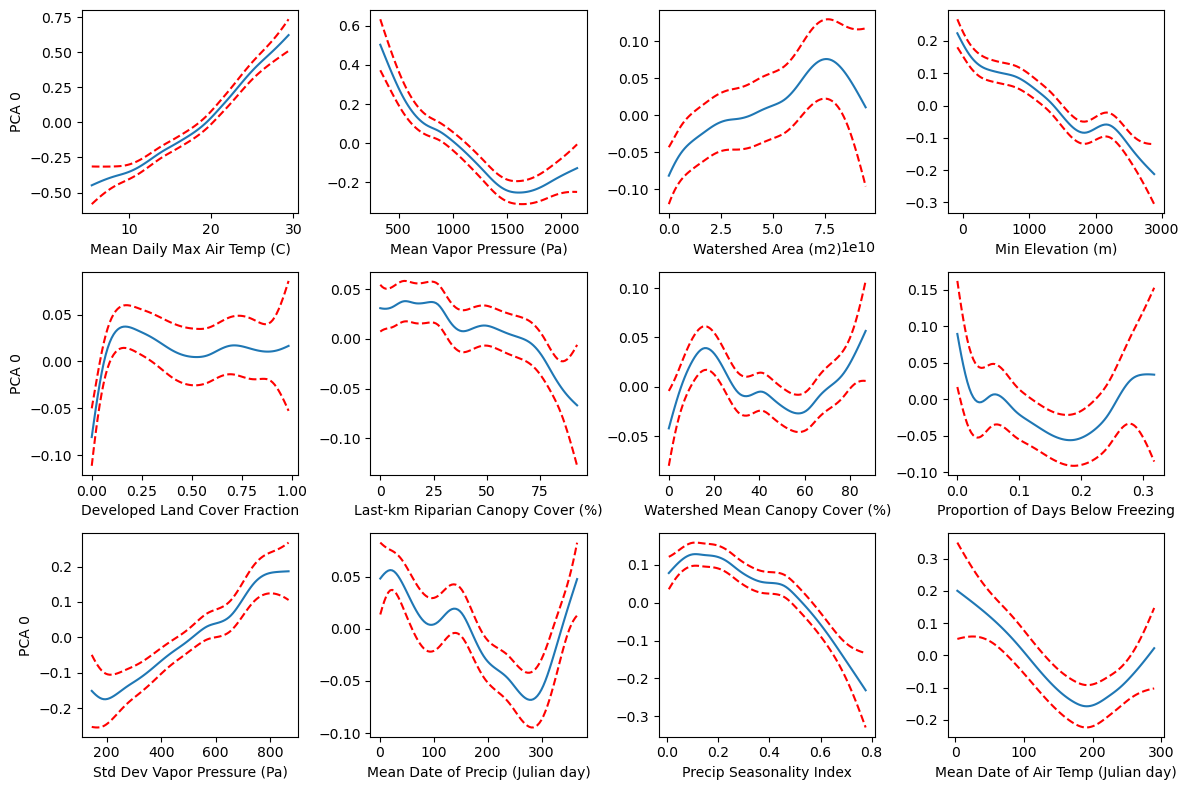

In [59]:
pdps(gam0, False, rename(var0), "PCA 0", "results/PCA_PDPs/GAM0.png")

## PCA1

Reference: R2 0.606, GCV 0.994 - lambda 20, 12 covariates, including forest.

Canopy%: R2 0.593, GCV 1.001 - lambda 35, 12 covariates, including canopy.

No s/a: R2 0.566, GCV 1.007 - lambda 108, 10 covariates.

Canopy%/0: no change.

Rescaled 1: R2 0.65, GCV 3.2 - lambda 32, 13 covariates.

FWPCA: R2 0.65, GCV 0.0016 - lambda 30, 13 covariates. Here, performance is way worse with a linear model.

FWPCA w/drop: R2 0.61, GCV 0.0016 - lambda 30, 10 covariates.

In [38]:
(var1, lam1, gcv1) = tune_gcv(list(allvar), 10, None, X, Y["pca1"])
print(var1, lam1, gcv1)
eq1 = eqmk(len(var1))
gam1 = LinearGAM(eq1, lam=lam1).fit(X[var1], Y["pca1"])
noise1 = np.sqrt(np.mean((gam1.predict(X[var1]) - Y["pca1"])**2))
gam1.summary()

|Lambda: 30.00 | Dropped: canopy | GCV: 0.0017
|Lambda: 90.00 | Dropped: prcp | GCV: 0.0017
|Lambda: 90.00 | Dropped: developed | GCV: 0.0017
|Lambda: 90.00 | Dropped: prcp_phi | GCV: 0.0017
|Lambda: 30.00 | Dropped: prcp_index | GCV: 0.0017
|Lambda: 30.00 | Dropped: ice_snow | GCV: 0.0017
|Lambda: 30.00 | Dropped: cold_prcp | GCV: 0.0016
|Lambda: 30.00 | Dropped: water | GCV: 0.0016
|['tmax', 'vp', 'area', 'elev_min', 'slope', 'wetland', 'ws_canopy', 'frozen', 'vp_sd', 'tmax_phi'] 30.0 0.0016427091000803867
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     48.6545
Link Function:                     IdentityLink Log Likelihood:                               -288119.0528
Number of Samples:                          921 AIC:      

/tmp/ipykernel_2489597/397279491.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam1.summary()


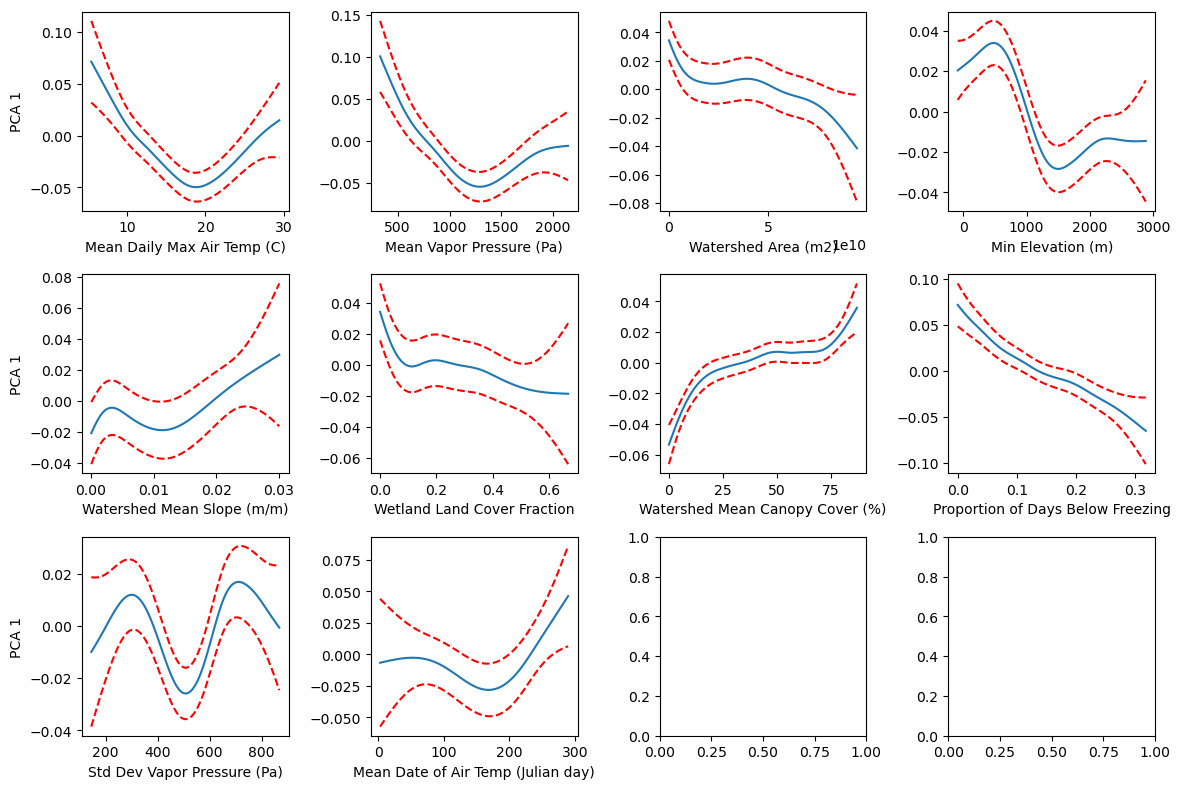

In [60]:
pdps(gam1, False, rename(var1), "PCA 1", "results/PCA_PDPs/GAM1.png")

## PCA2

Reference: R2 0.353, GCV 0.667, 12 covariates, including forest.

Canopy%: R2 0.356, GCV 0.656, lambda 120, 11 covariates including canopy.

No s/a: no change.

C/0: no change.

In [40]:
(var2, lam2, gcv2) = tune_gcv(list(allvar), 12, None, X, Y["pca2"])
print(var2, lam2, gcv2)
eq2 = eqmk(len(var2))
gam2 = LinearGAM(eq2, lam=lam2).fit(X[var2], Y["pca2"])
noise2 = np.sqrt(np.mean((gam2.predict(X[var2]) - Y["pca2"])**2))
gam2.summary()

|Lambda: 36.00 | Dropped: canopy | GCV: 0.0000
|Lambda: 108.00 | Dropped: cold_prcp | GCV: 0.0000
|Lambda: 324.00 | Dropped: area | GCV: 0.0000
|Lambda: 324.00 | Dropped: vp_sd | GCV: 0.0000
|Lambda: 108.00 | Dropped: wetland | GCV: 0.0000
|Lambda: 108.00 | Dropped: ws_canopy | GCV: 0.0000
|Lambda: 108.00 | Dropped: vp | GCV: 0.0000
|Lambda: 108.00 | Dropped: developed | GCV: 0.0000
|['tmax', 'prcp', 'elev_min', 'slope', 'ice_snow', 'water', 'frozen', 'prcp_phi', 'prcp_index', 'tmax_phi'] 108.0 2.0788078748367417e-05
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      34.537
Link Function:                     IdentityLink Log Likelihood:                             -22849899.3181
Number of Samples:                          921 A

/tmp/ipykernel_2489597/2084797622.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam2.summary()


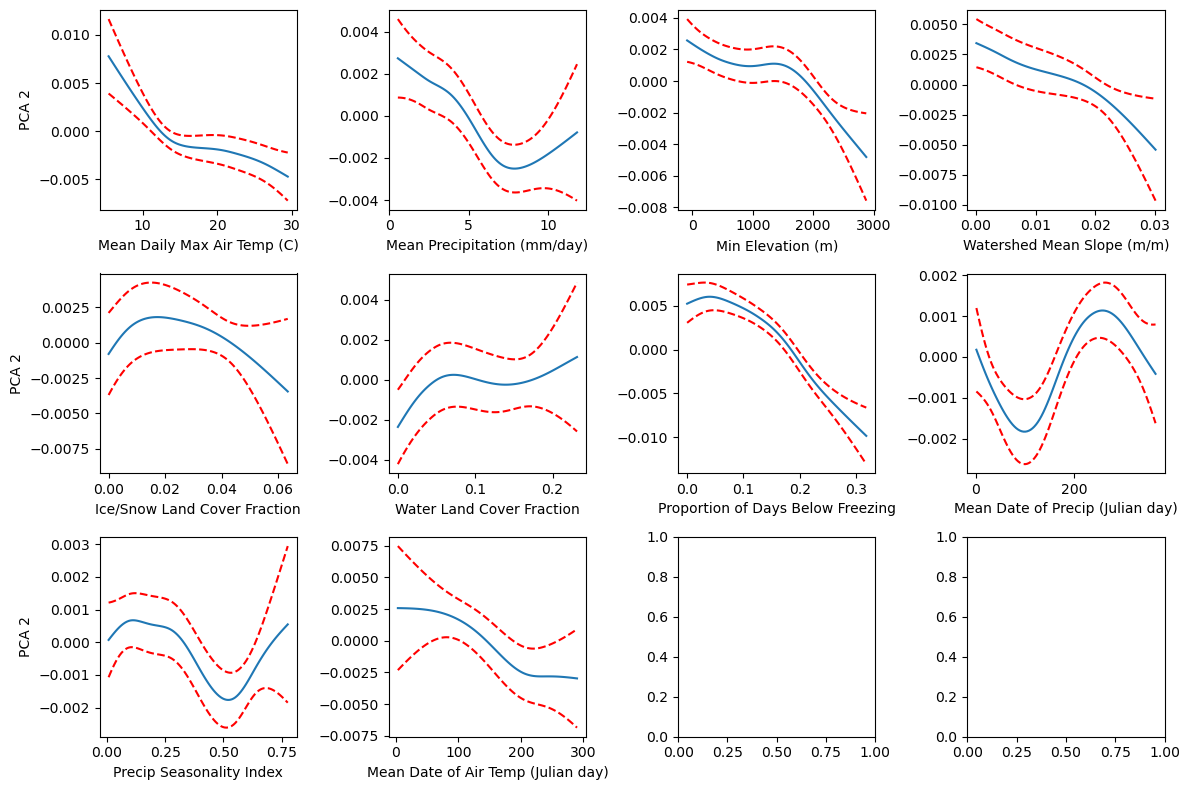

In [41]:
pdps(gam2, False, rename(var2), "PCA 2", "results/PCA_PDPs/GAM2.png")

## PCA3

Reference: R2 0.278, GCV 0.625, lambda 333, 11 covariates *not* including forest.

Canopy%: R2 0.285, GCV 0.622, lambda 300, 11 covariates including canopy.

No s/a: no change.

C/0: no change.

In [42]:
(var3, lam3, gcv3) = tune_gcv(list(allvar), 10, None, X, Y["pca3"])
print(var3, lam3, gcv3)
eq3 = eqmk(len(var3))
gam3 = LinearGAM(eq3, lam=lam3).fit(X[var3], Y["pca3"])
noise3 = np.sqrt(np.mean((gam3.predict(X[var3]) - Y["pca3"])**2))
gam3.summary()

|Lambda: 30.00 | Dropped: developed | GCV: 0.0000
|Lambda: 90.00 | Dropped: slope | GCV: 0.0000
|Lambda: 270.00 | Dropped: tmax_phi | GCV: 0.0000
|Lambda: 810.00 | Dropped: prcp | GCV: 0.0000
|Lambda: 810.00 | Dropped: ice_snow | GCV: 0.0000
|Lambda: 810.00 | Dropped: area | GCV: 0.0000
|['tmax', 'vp', 'elev_min', 'wetland', 'water', 'canopy', 'ws_canopy', 'frozen', 'cold_prcp', 'vp_sd', 'prcp_phi', 'prcp_index'] 810 1.7250608665203897e-05
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     27.9355
Link Function:                     IdentityLink Log Likelihood:                             -27366172.0779
Number of Samples:                          921 AIC:                                         54732402.0268
                     

/tmp/ipykernel_2489597/4088228967.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam3.summary()


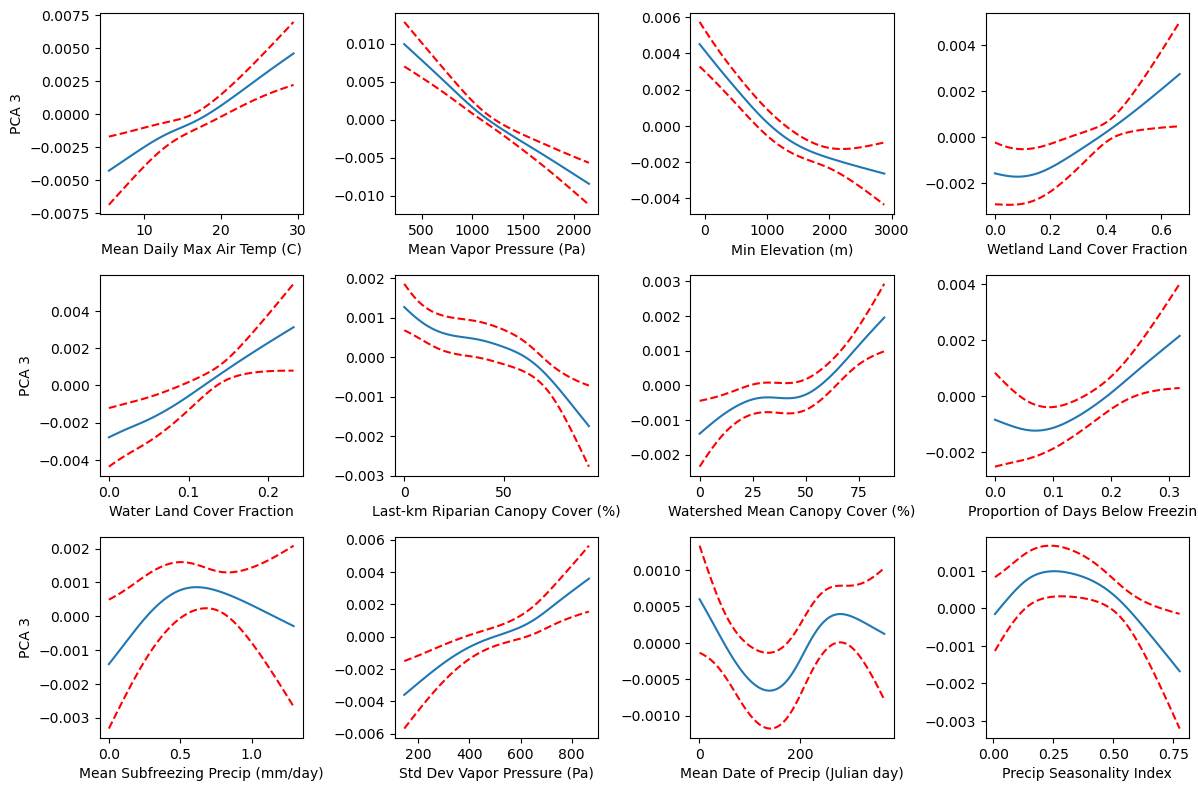

In [43]:
pdps(gam3, False, rename(var3), "PCA 3", "results/PCA_PDPs/GAM3.png")

## PCA4

Reference: R2 0.290, GCV 0.509, lambda 100, 13 covariates not including forest.

Canopy%: no change.

No s/a: R2 0.274, GCV 0.520, lambda 33, 9 covariates (now including watershed canopy)

C/0: no change.

In [44]:
(var4, lam4, gcv4) = tune_gcv(list(allvar), 10, None, X, Y["pca4"])
print(var4, lam4, gcv4)
eq4 = eqmk(len(var4))
gam4 = LinearGAM(eq4, lam=lam4).fit(X[var4], Y["pca4"])
noise4 = np.sqrt(np.mean((gam4.predict(X[var4]) - Y["pca4"])**2))
gam4.summary()

|Lambda: 30.00 | Dropped: prcp_index | GCV: 0.0000
|Lambda: 90.00 | Dropped: developed | GCV: 0.0000
|Lambda: 270.00 | Dropped: ice_snow | GCV: 0.0000
|Lambda: 270.00 | Dropped: area | GCV: 0.0000
|Lambda: 270.00 | Dropped: cold_prcp | GCV: 0.0000
|Lambda: 270.00 | Dropped: water | GCV: 0.0000
|Lambda: 270.00 | Dropped: prcp | GCV: 0.0000
|['tmax', 'vp', 'elev_min', 'slope', 'wetland', 'canopy', 'ws_canopy', 'frozen', 'vp_sd', 'prcp_phi', 'tmax_phi'] 270 9.0870866692727e-06
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     33.0236
Link Function:                     IdentityLink Log Likelihood:                             -52208435.4037
Number of Samples:                          921 AIC:                                        1

/tmp/ipykernel_2489597/295500050.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam4.summary()


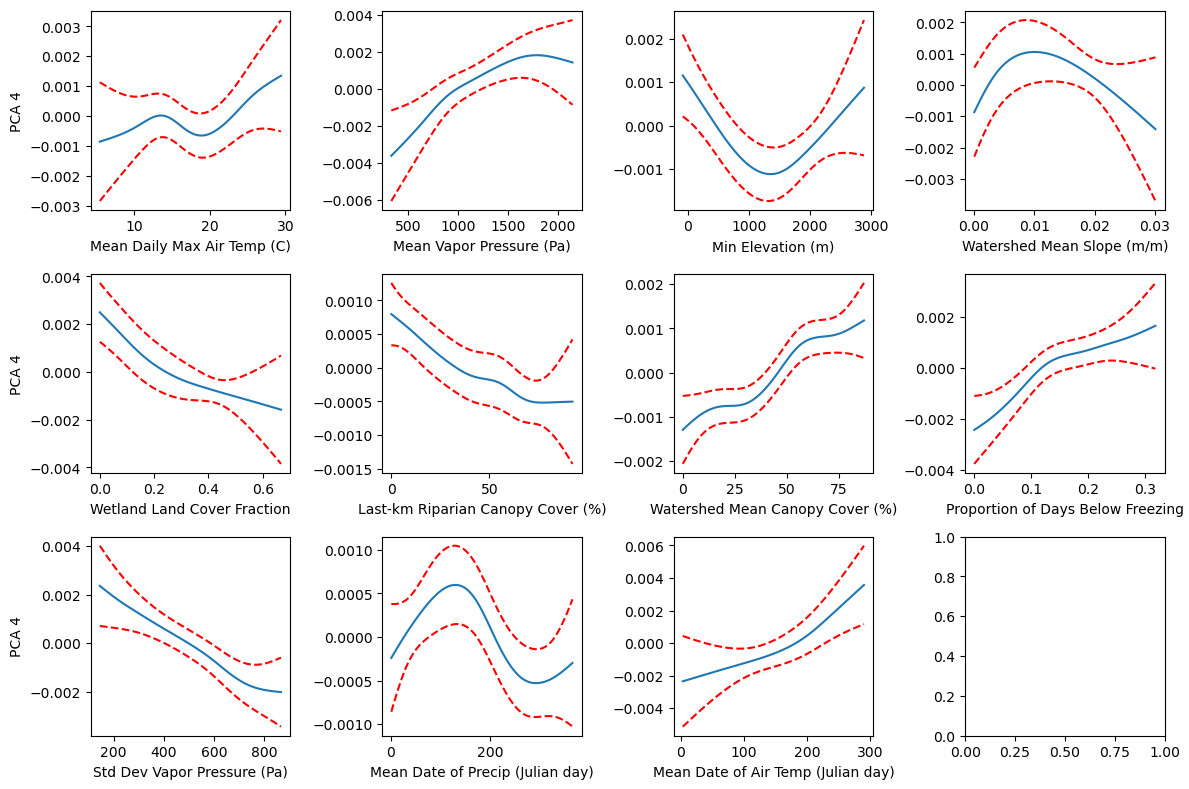

In [45]:
pdps(gam4, False, rename(var4), "PCA 4", "results/PCA_PDPs/GAM4.png")

## PCA5

Reference: R2 0.446, GCV 0.389, lambda 100, 13 covariates including forest.

Canopy%: R2 0.430, GCV 0.386, lambda 100, 10 covariates including canopy.

No s/a: no change.

C/0: no change.

In [46]:
(var5, lam5, gcv5) = tune_gcv(list(allvar), 10, None, X, Y["pca5"])
print(var5, lam5, gcv5)
eq5 = eqmk(len(var5))
gam5 = LinearGAM(eq5, lam=lam5).fit(X[var5], Y["pca5"])
noise5 = np.sqrt(np.mean((gam5.predict(X[var5]) - Y["pca5"])**2))
gam5.summary()

|Lambda: 30.00 | Dropped: developed | GCV: 0.0000
|Lambda: 90.00 | Dropped: prcp | GCV: 0.0000
|Lambda: 270.00 | Dropped: canopy | GCV: 0.0000
|Lambda: 270.00 | Dropped: ice_snow | GCV: 0.0000
|Lambda: 270.00 | Dropped: elev_min | GCV: 0.0000
|['tmax', 'vp', 'area', 'slope', 'wetland', 'water', 'ws_canopy', 'frozen', 'cold_prcp', 'vp_sd', 'prcp_phi', 'prcp_index', 'tmax_phi'] 270 6.696574777935688e-06
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     36.7895
Link Function:                     IdentityLink Log Likelihood:                             -71103686.1481
Number of Samples:                          921 AIC:                                        142207447.8753
                                                AICc:       

/tmp/ipykernel_2489597/1977265968.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam5.summary()


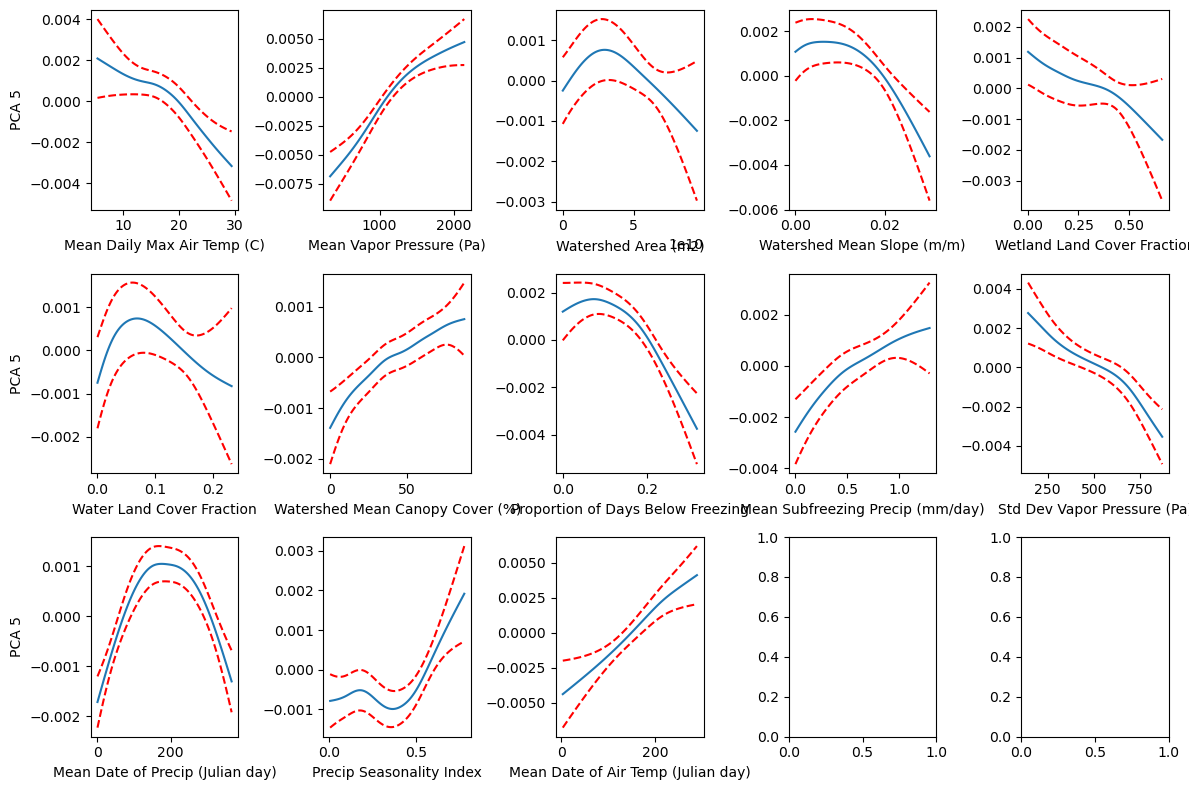

In [47]:
pdps(gam5, False, rename(var5), "PCA 5", "results/PCA_PDPs/GAM5.png")

## PCA6

Reference: R2 0.438, GCV 0.310, lambda 100, 10 covariates not including forest.

Canopy%: no change.

No s/a: R2 0.450, GCV 0.310, lambda 33, 9 covariates

C/0: no change.

In [48]:
(var6, lam6, gcv6) = tune_gcv(list(allvar), 10, None, X, Y["pca6"])
print(var6, lam6, gcv6)
eq6 = eqmk(len(var6))
gam6 = LinearGAM(eq6, lam=lam6).fit(X[var6], Y["pca6"])
noise6 = np.sqrt(np.mean((gam6.predict(X[var6]) - Y["pca6"])**2))
gam6.summary()

|Lambda: 30.00 | Dropped: canopy | GCV: 0.0000
|Lambda: 90.00 | Dropped: area | GCV: 0.0000
|Lambda: 270.00 | Dropped: frozen | GCV: 0.0000
|Lambda: 270.00 | Dropped: tmax_phi | GCV: 0.0000
|Lambda: 270.00 | Dropped: ice_snow | GCV: 0.0000
|Lambda: 270.00 | Dropped: developed | GCV: 0.0000
|['tmax', 'prcp', 'vp', 'elev_min', 'slope', 'wetland', 'water', 'ws_canopy', 'cold_prcp', 'vp_sd', 'prcp_phi', 'prcp_index'] 270 4.712217704702757e-06
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     35.1275
Link Function:                     IdentityLink Log Likelihood:                            -100889581.5417
Number of Samples:                          921 AIC:                                        201779235.3384
                      

/tmp/ipykernel_2489597/3846794831.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam6.summary()


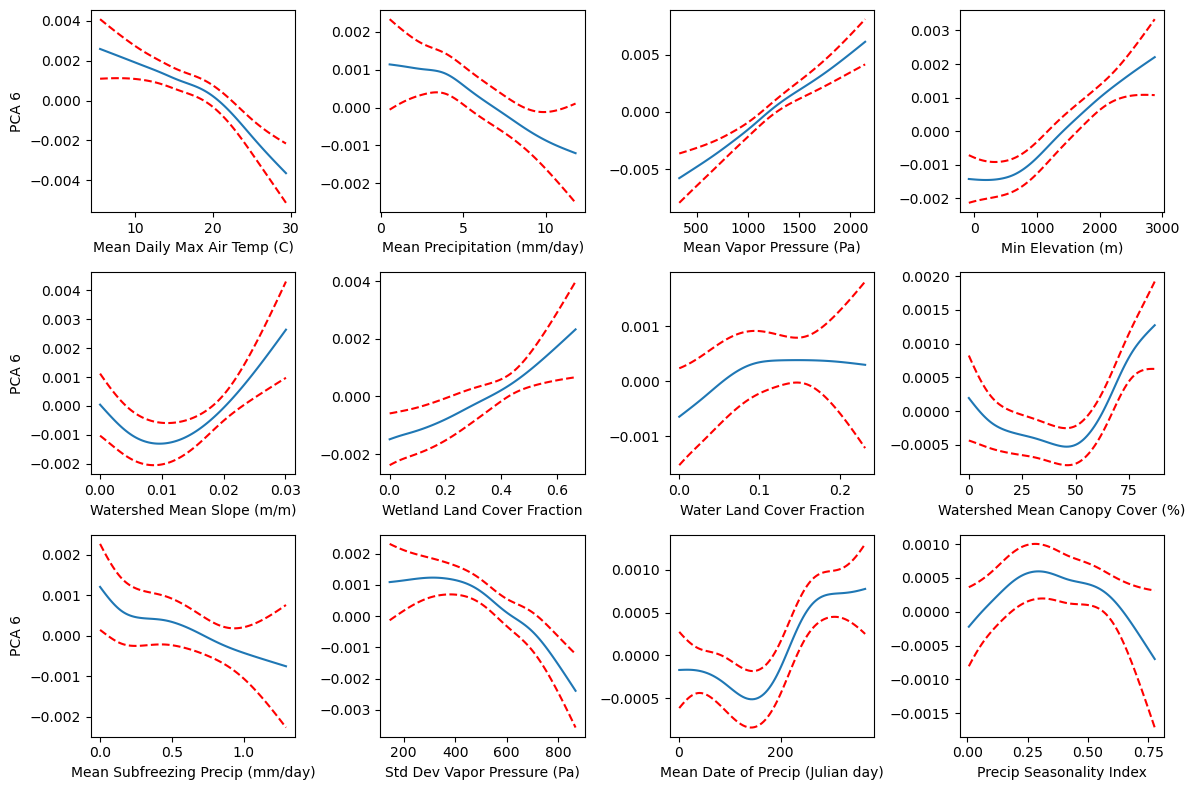

In [49]:
pdps(gam6, False, rename(var6), "PCA 6", "results/PCA_PDPs/GAM6.png")

## PCA7

Reference: R2 0.302, GCV 0.330, lambda 37, 8 covariates not including forest.

Canopy%: R2 0.283, GCV 0.330, lambda 105, 8 covariates not including canopy.  It seems to have affected the tuning, but not the final variable set.

No s/a: R2 0.277, GCV 0.330, lambda 316, 10 covariates

C/0: no change.

In [50]:
(var7, lam7, gcv7) = tune_gcv(list(allvar), 10, None, X, Y["pca7"])
print(var7, lam7, gcv7)
eq7 = eqmk(len(var7))
gam7 = LinearGAM(eq7, lam=lam7).fit(X[var7], Y["pca7"])
noise7 = np.sqrt(np.mean((gam7.predict(X[var7]) - Y["pca7"])**2))
gam7.summary()

|Lambda: 30.00 | Dropped: ws_canopy | GCV: 0.0000
|Lambda: 90.00 | Dropped: prcp_phi | GCV: 0.0000
|Lambda: 270.00 | Dropped: tmax_phi | GCV: 0.0000
|Lambda: 270.00 | Dropped: prcp_index | GCV: 0.0000
|Lambda: 270.00 | Dropped: prcp | GCV: 0.0000
|Lambda: 270.00 | Dropped: vp | GCV: 0.0000
|Lambda: 270.00 | Dropped: canopy | GCV: 0.0000
|Lambda: 90.00 | Dropped: cold_prcp | GCV: 0.0000
|Lambda: 90.00 | Dropped: slope | GCV: 0.0000
|Lambda: 90.00 | Dropped: developed | GCV: 0.0000
|Lambda: 30.00 | Dropped: ice_snow | GCV: 0.0000
|['tmax', 'area', 'elev_min', 'wetland', 'water', 'frozen', 'vp_sd'] 30.0 2.7515613424104207e-06
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     34.9322
Link Function:                     IdentityLink 

/tmp/ipykernel_2489597/285521930.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam7.summary()


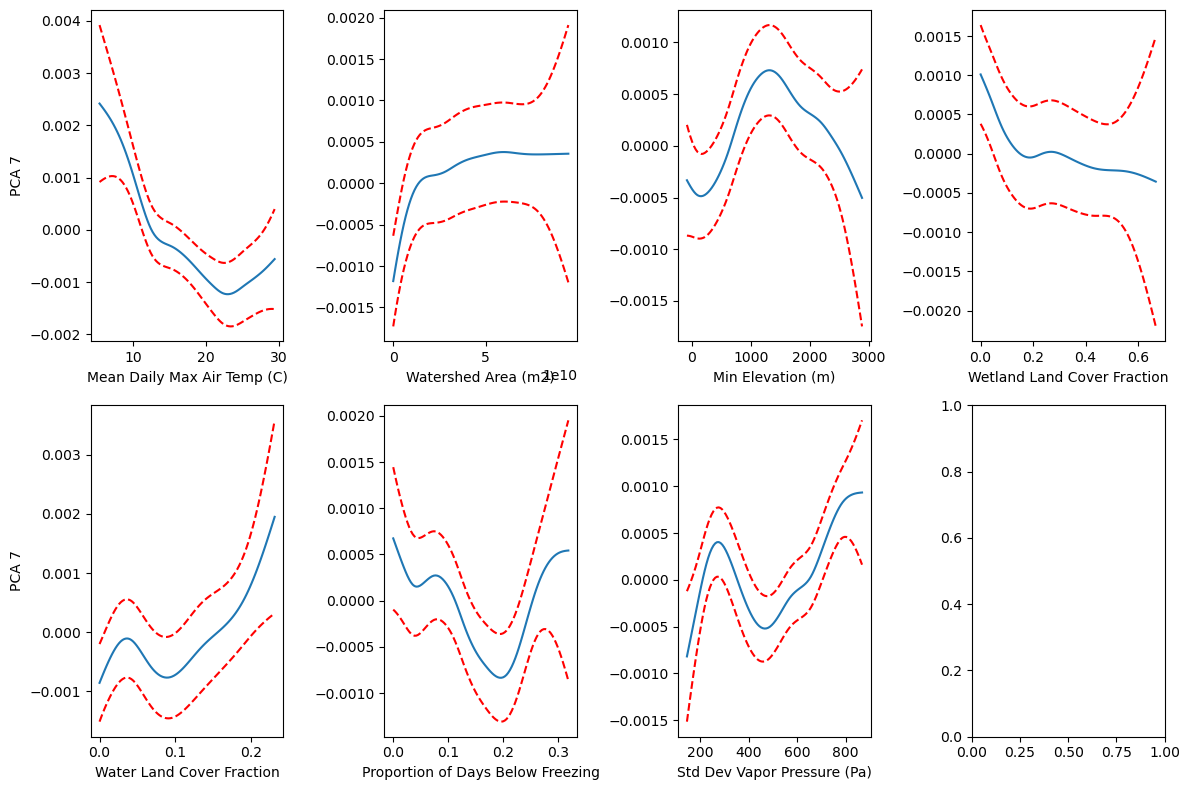

In [51]:
pdps(gam7, False, rename(var7), "PCA 7", "results/PCA_PDPs/GAM7.png")

## PCA8

Reference: R2 0.204, GCV 0.272, lambda 949, 12 covariates including forest.

Canopy%: R2 0.234, GCV 0.270, lambda 316, 13 covariates including canopy.

No s/a: R2 0.194, GCV 0.275, lambda 948, 12 covariates

C/0: R2 0.231, GCV 0.268, lambda 105, 9 covariates

In [52]:
(var8, lam8, gcv8) = tune_gcv(list(allvar), 10, None, X, Y["pca8"])
print(var8, lam8, gcv8)
eq8 = eqmk(len(var8))
gam8 = LinearGAM(eq8, lam=lam8).fit(X[var8], Y["pca8"])
noise8 = np.sqrt(np.mean((gam8.predict(X[var8]) - Y["pca8"])**2))
gam8.summary()

|Lambda: 30.00 | Dropped: ws_canopy | GCV: 0.0000
|Lambda: 90.00 | Dropped: canopy | GCV: 0.0000
|Lambda: 270.00 | Dropped: area | GCV: 0.0000
|Lambda: 810.00 | Dropped: vp | GCV: 0.0000
|Lambda: 2430.00 | Dropped: water | GCV: 0.0000
|Lambda: 2430.00 | Dropped: slope | GCV: 0.0000
|Lambda: 2430.00 | Dropped: cold_prcp | GCV: 0.0000
|Lambda: 2430.00 | Dropped: prcp | GCV: 0.0000
|Lambda: 2430.00 | Dropped: tmax | GCV: 0.0000
|['elev_min', 'wetland', 'developed', 'ice_snow', 'frozen', 'vp_sd', 'prcp_phi', 'prcp_index', 'tmax_phi'] 2430 1.3445112513284182e-06
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     15.8903
Link Function:                     IdentityLink Log Likelihood:                            -347353603.5419
Number o

/tmp/ipykernel_2489597/1562968131.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam8.summary()


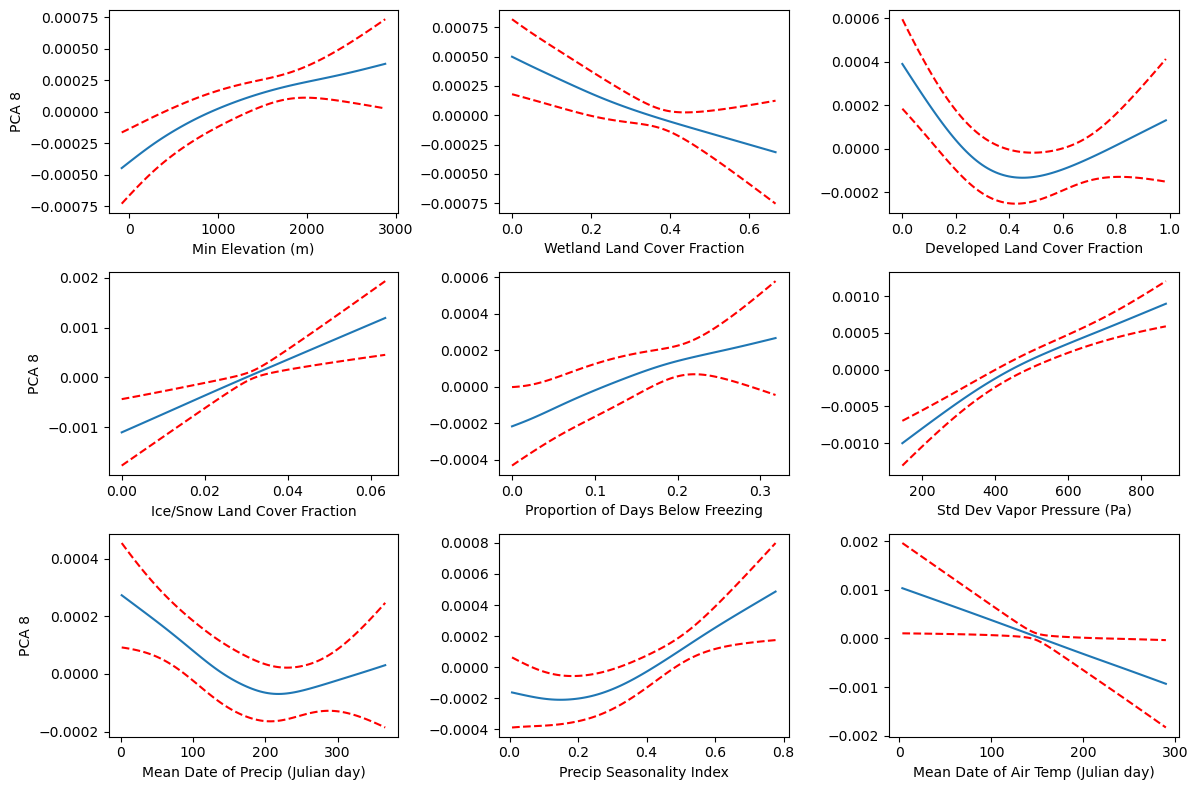

In [53]:
pdps(gam8, False, rename(var8), "PCA 8", "results/PCA_PDPs/GAM8.png")

## Estimate Total Variance Captured

Since the PCAs are all uncorrelated, we can straightforwardly estimate how much of the variance was captured as the sum of the products of variance explained by each PC and estimated variance in the PC captured by the respective coefficient estimation model.

Initial run (no lat/lon/prcp-sd/srad): 49.26%, median hindcast RMSE 2.2 C, spatial 2.2 C, elevation 2.9 C.  Low-capture PCAs are 8 (0.7%), 7 (1.4%), and 4 (2%).  However, dropping PCA8 creates a surprisingly large penalty to performance.

Frozen removed: 47.96%

Tmax index removed: 48.11%

Canopy instead of forest: 49.06%.  But it bumps a few of the weak ones up, so it's worth a try.  Median hindcast RMSE 2.2 C (effect is nonzero but minuscule), spatial 2.3 C, elevation 2.9 C - but it does *really well* for the highest elevations.

No slope/area: 48.1%, pretty severe downgrade.

Canopy, 0-tolerance: 49.05%.

Note the low figure is due to tuning for cross-validation.  If we tune for R2 (maximum capture), it goes up to 78%, with 64-85% captured across the PCs.  Tuning for AIC (performance-complexity balance), it's 72%.  R2-tuning with limited variables captures 70% (54-79%).

Tuning for GCV *without* dropping variables gets us: 50.8%.  Not worth it.

Also note: several sets of variables seem to interact pretty strongly (frozen/tmax index, elev/elev/slope, possibly forest/riparian canopy).  I recommend testing modified versions where these are set for tensor interaction.  This is not supported by the autotuner here, so it has to be modified later.  There is an "interaction rewriter" function provided below.

With FWPCA, theoretical skill is 89%, with the first two PCs accounting for 86% and 2.9%. Dropping variables, we're at 87%, with 84% and 2.8%.

In [54]:
r2s = np.array([eval(f"gam{x}").statistics_["pseudo_r2"]["explained_deviance"] for x in range(9)])
weights = r2s * evr
print(r2s)
print(evr)
print(weights)
print(sum(weights))

[0.88414394 0.6144166  0.24688509 0.23878133 0.24466171 0.41325638
 0.23991752 0.3135272  0.08841864]
[9.53563232e-01 4.54765917e-02 3.08459024e-04 2.58636692e-04
 1.35093314e-04 1.26620539e-04 6.91489724e-05 4.47351965e-05
 1.74830130e-05]
[8.43087155e-01 2.79415730e-02 7.61539346e-05 6.17576127e-05
 3.30521614e-05 5.23267452e-05 1.65900503e-05 1.40257007e-05
 1.54582427e-06]
0.8712841796357272


## Plot GAMs By XVar

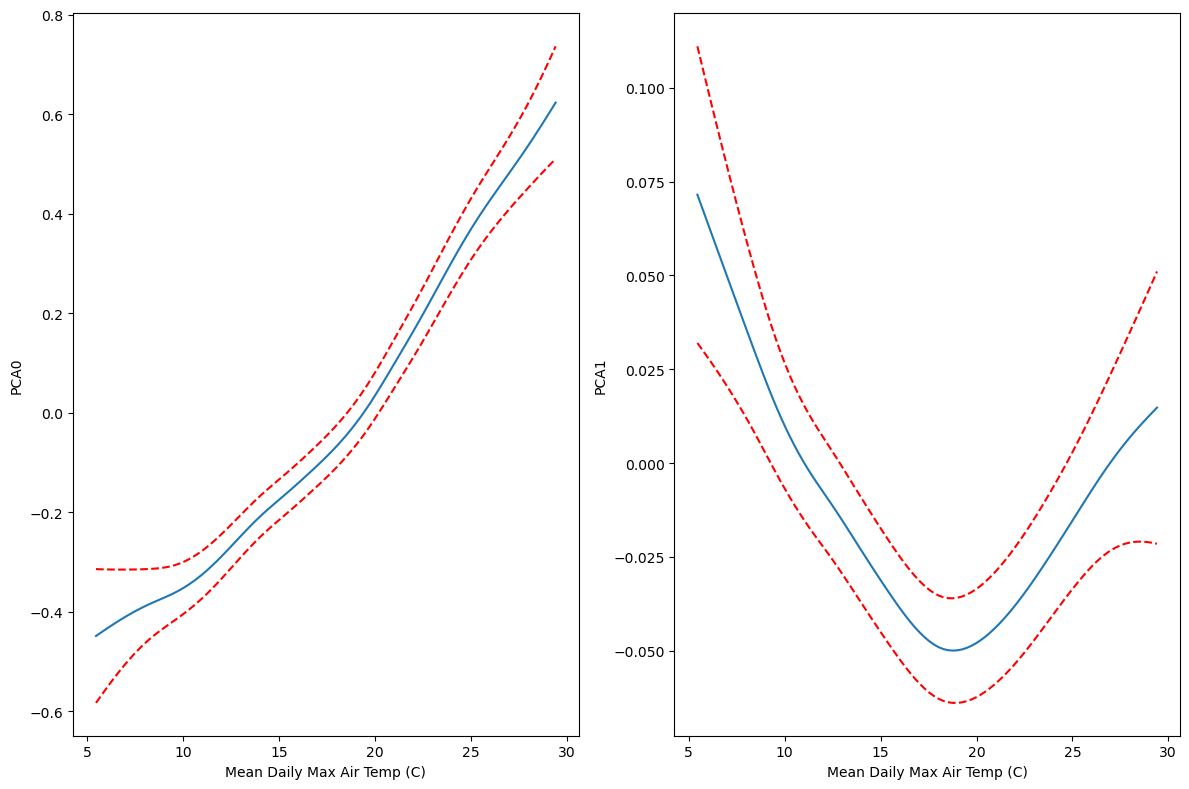

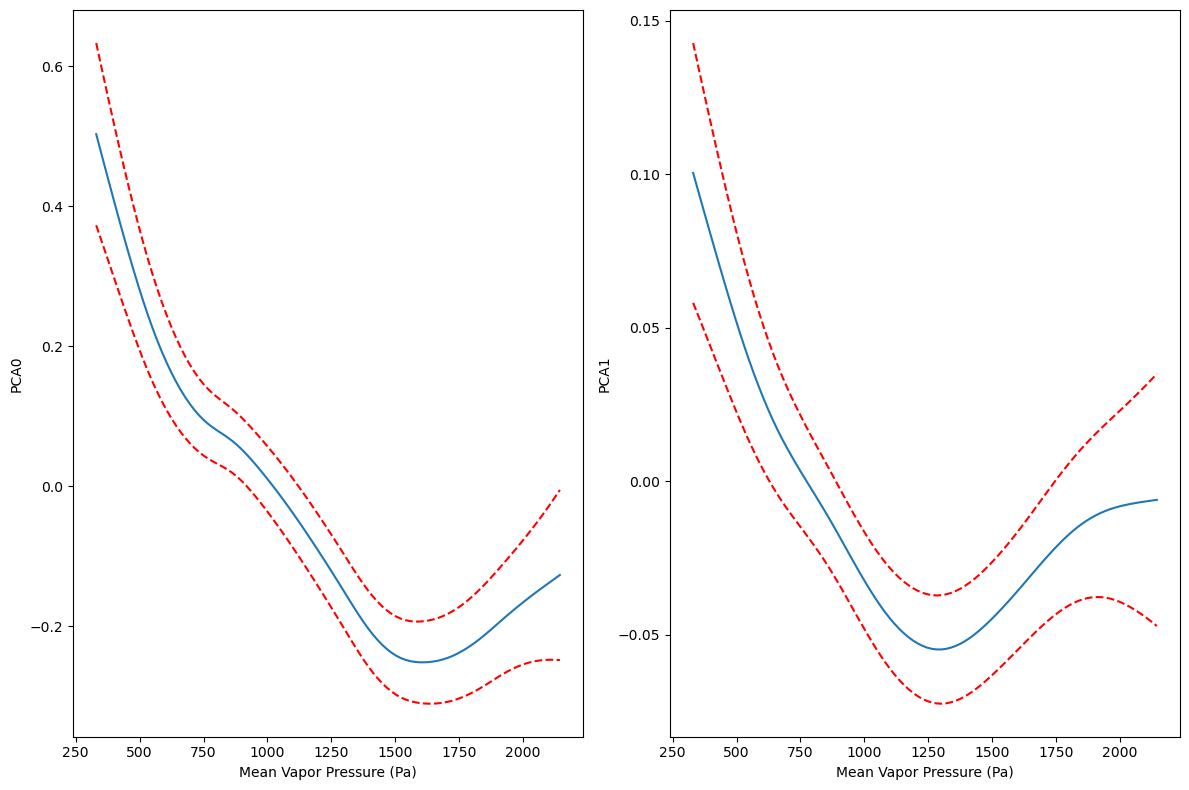

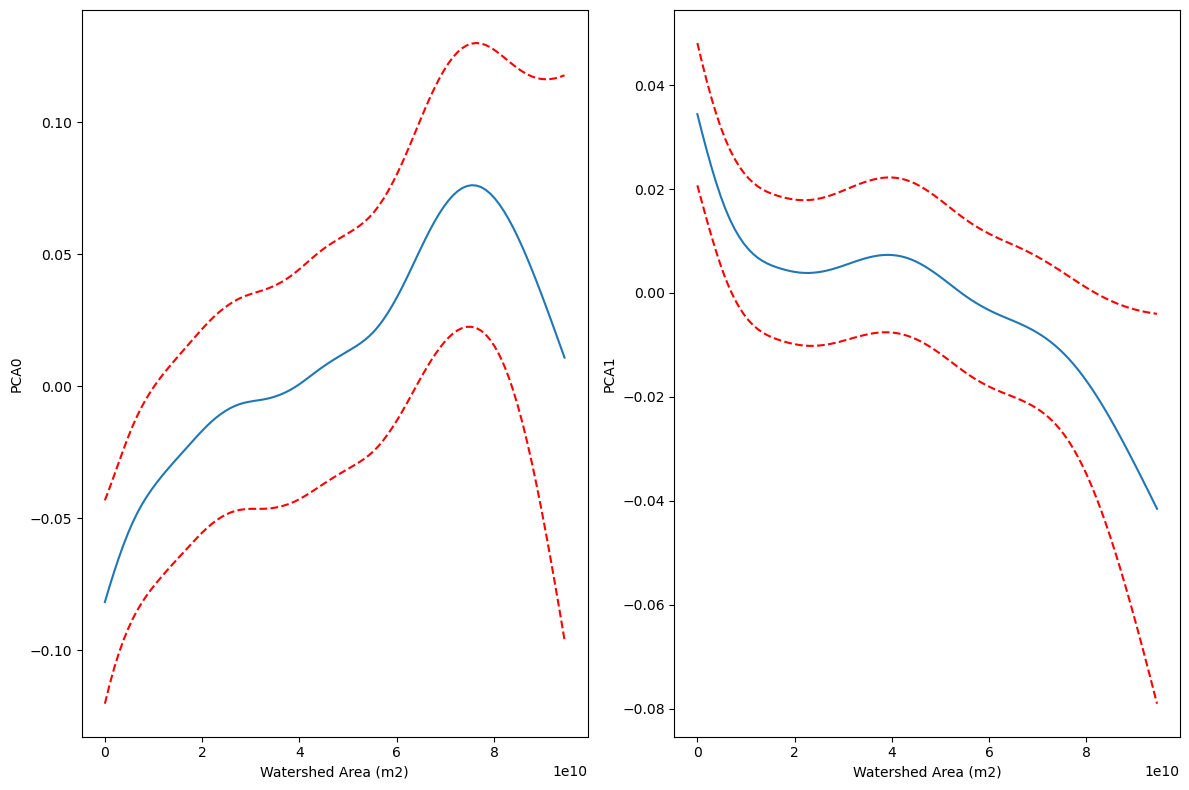

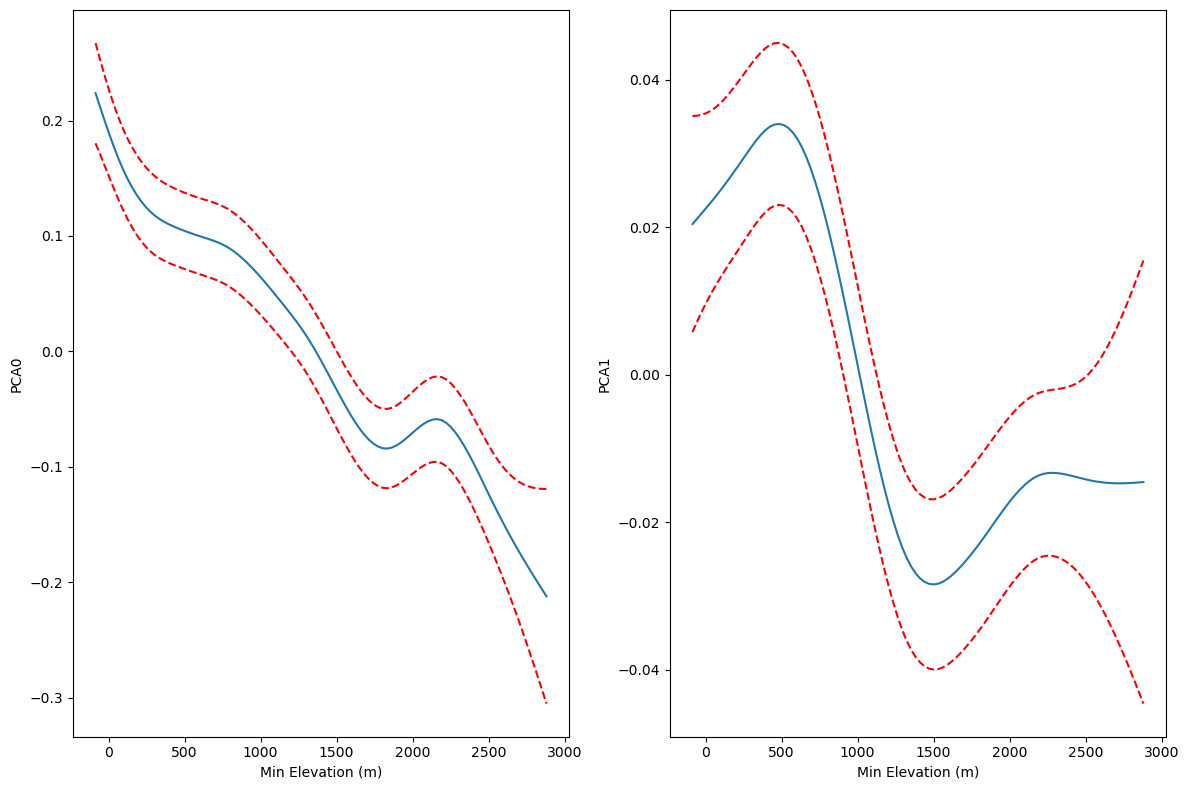

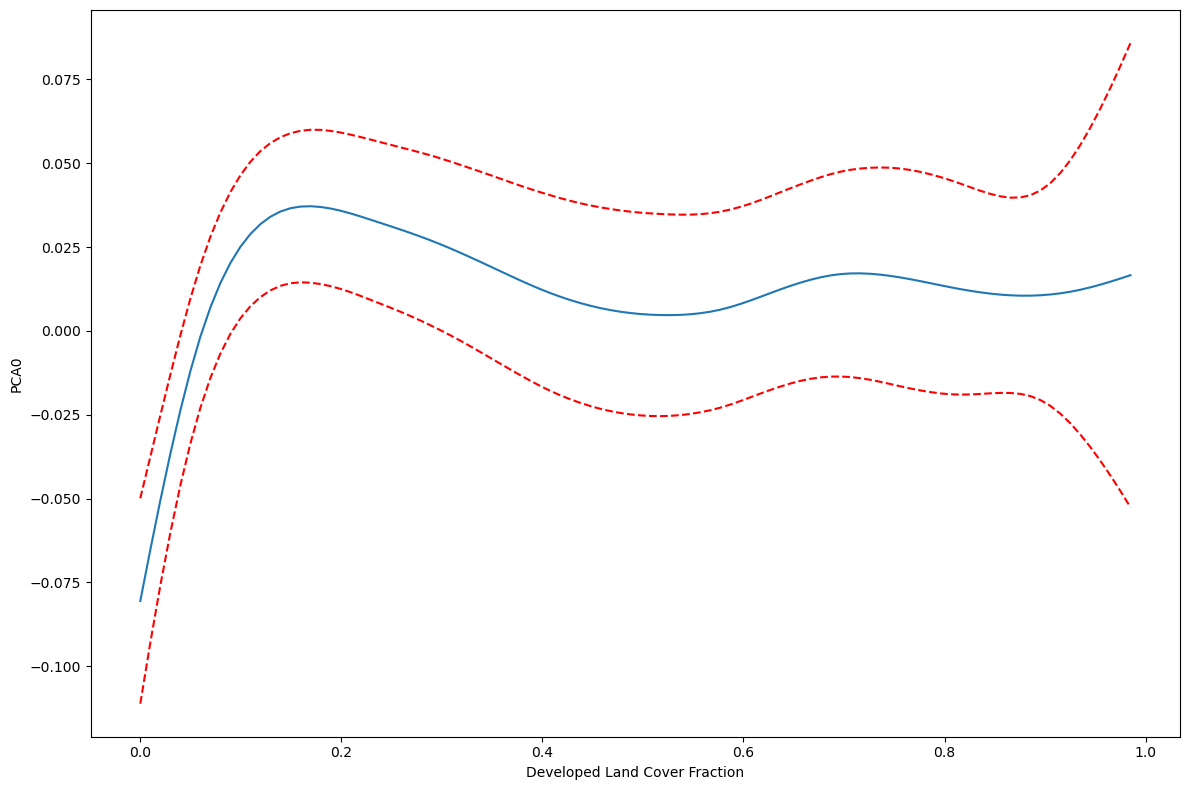

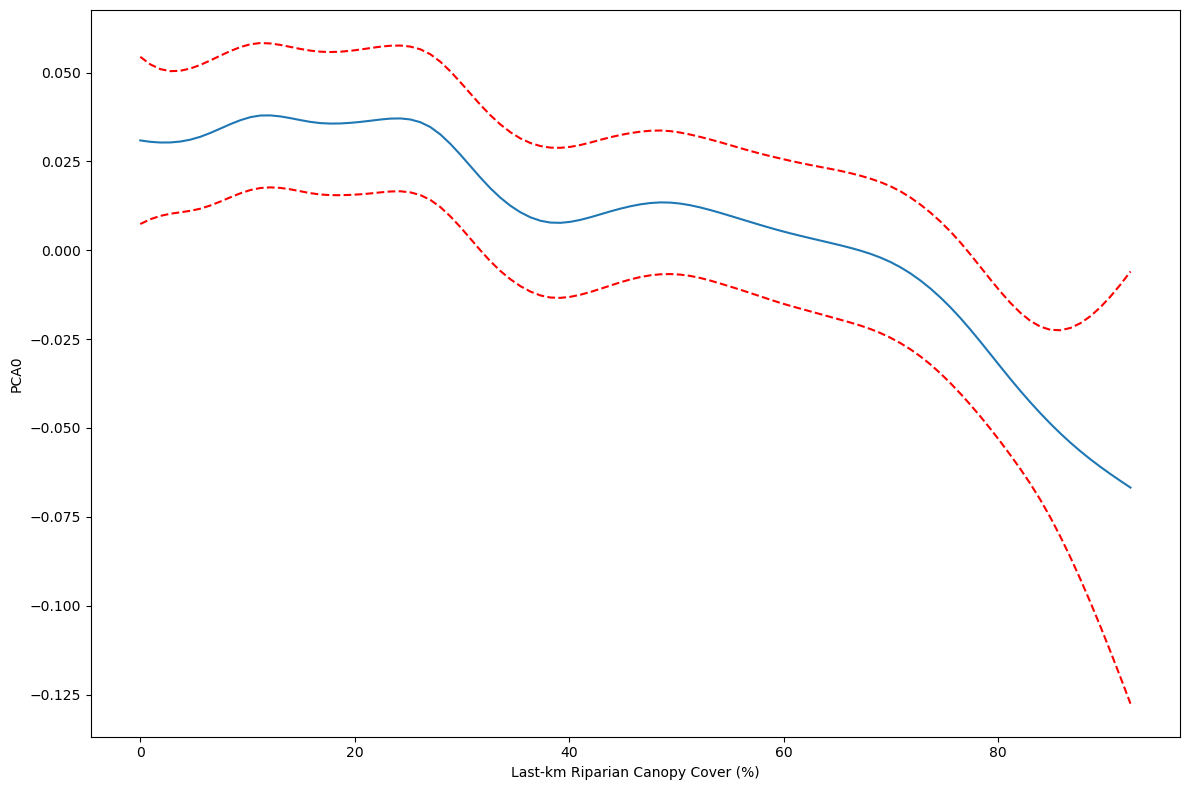

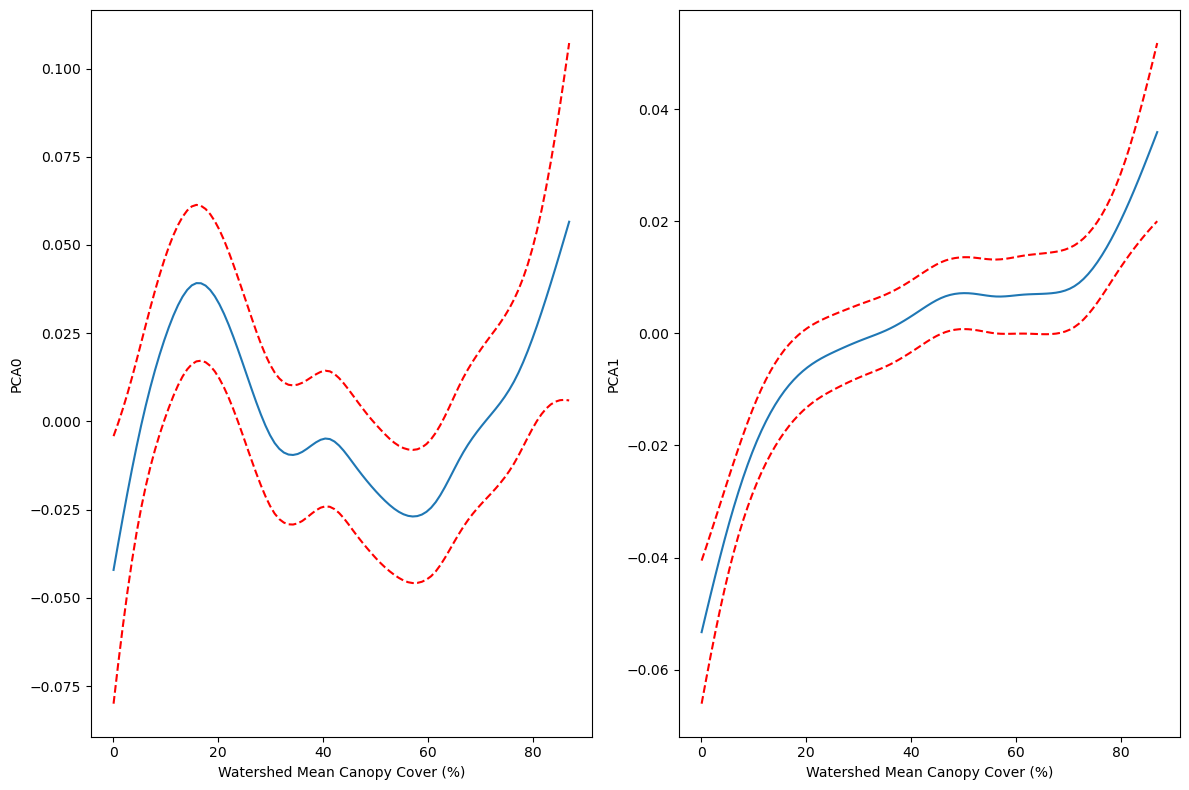

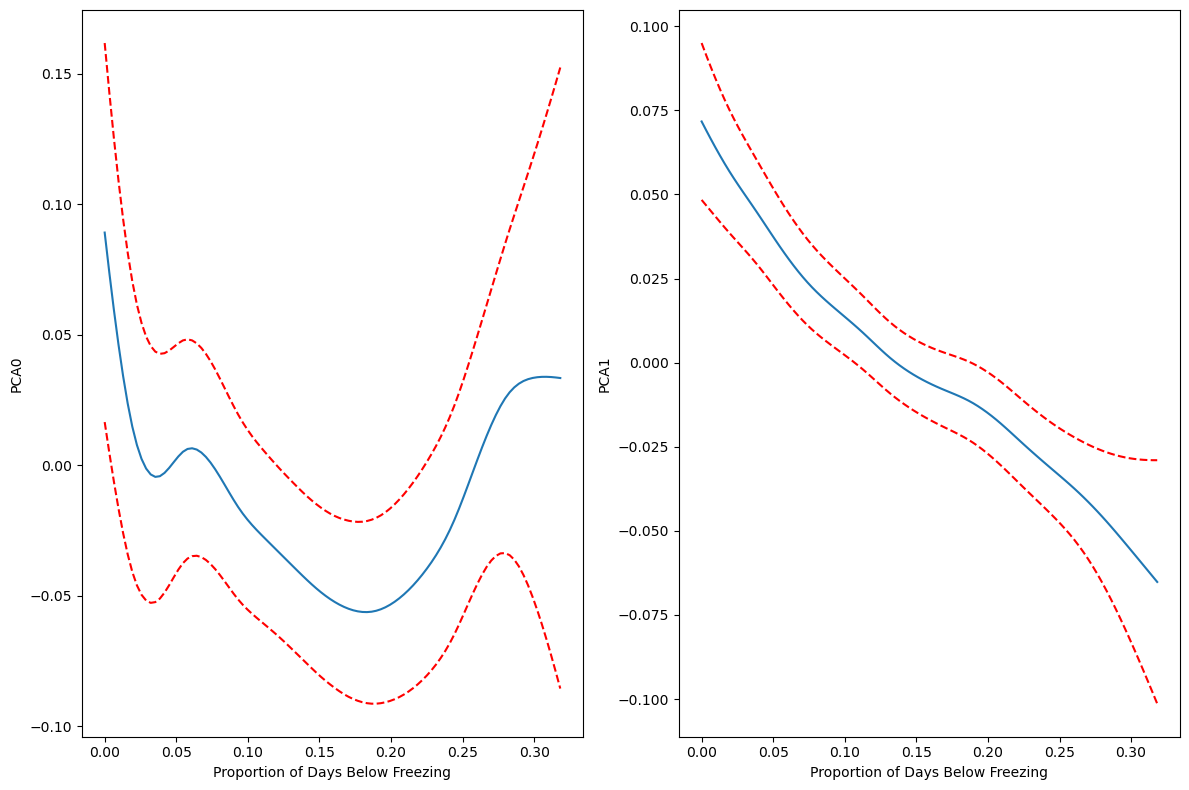

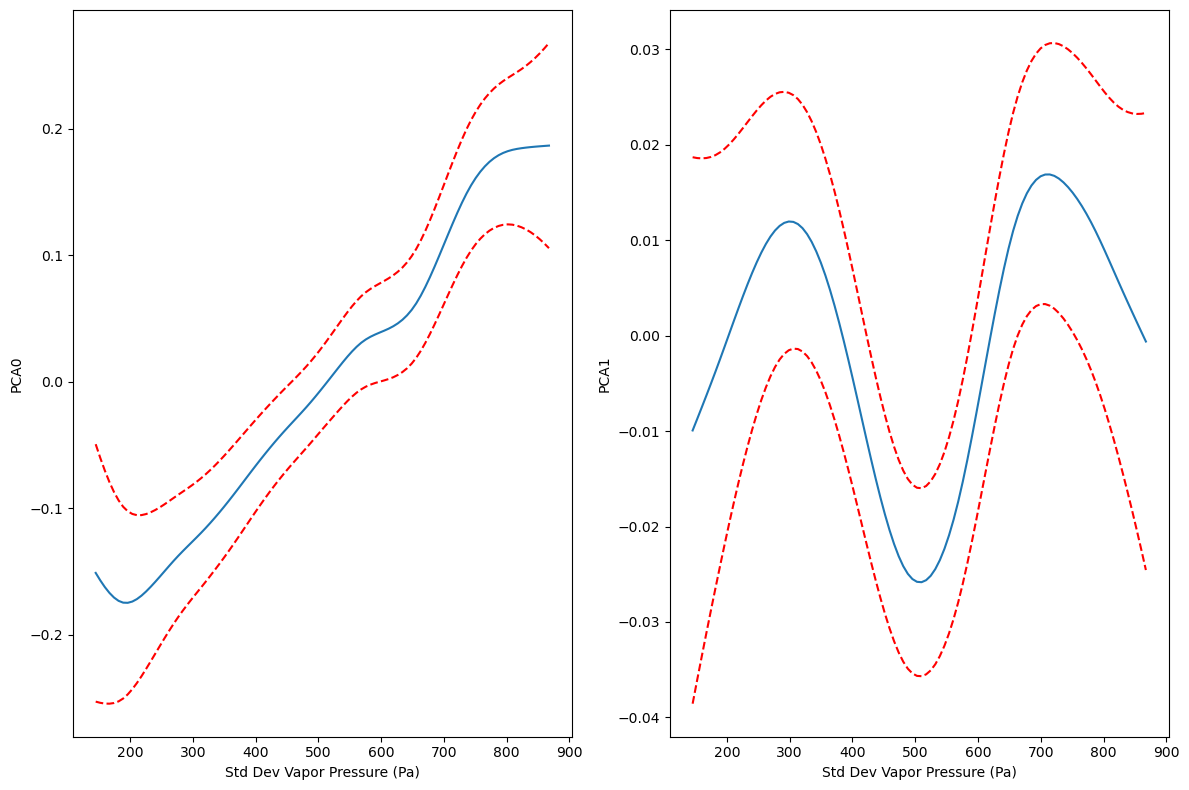

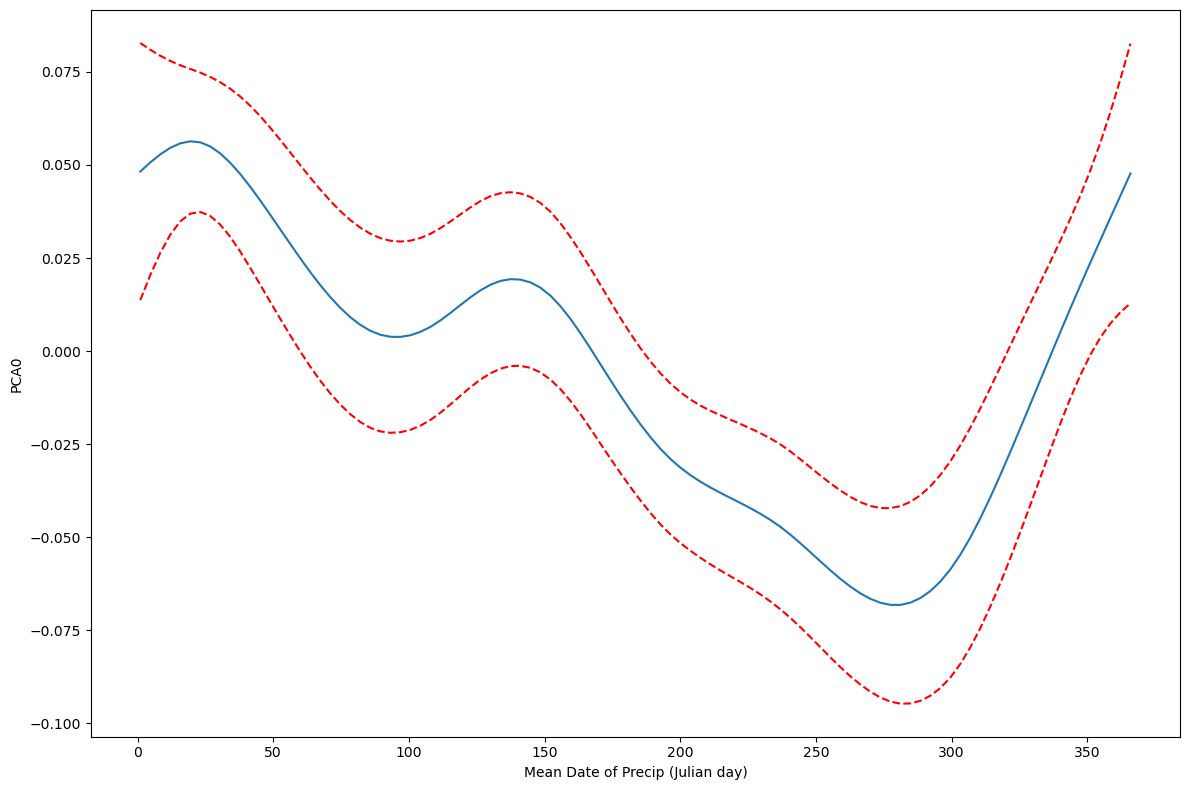

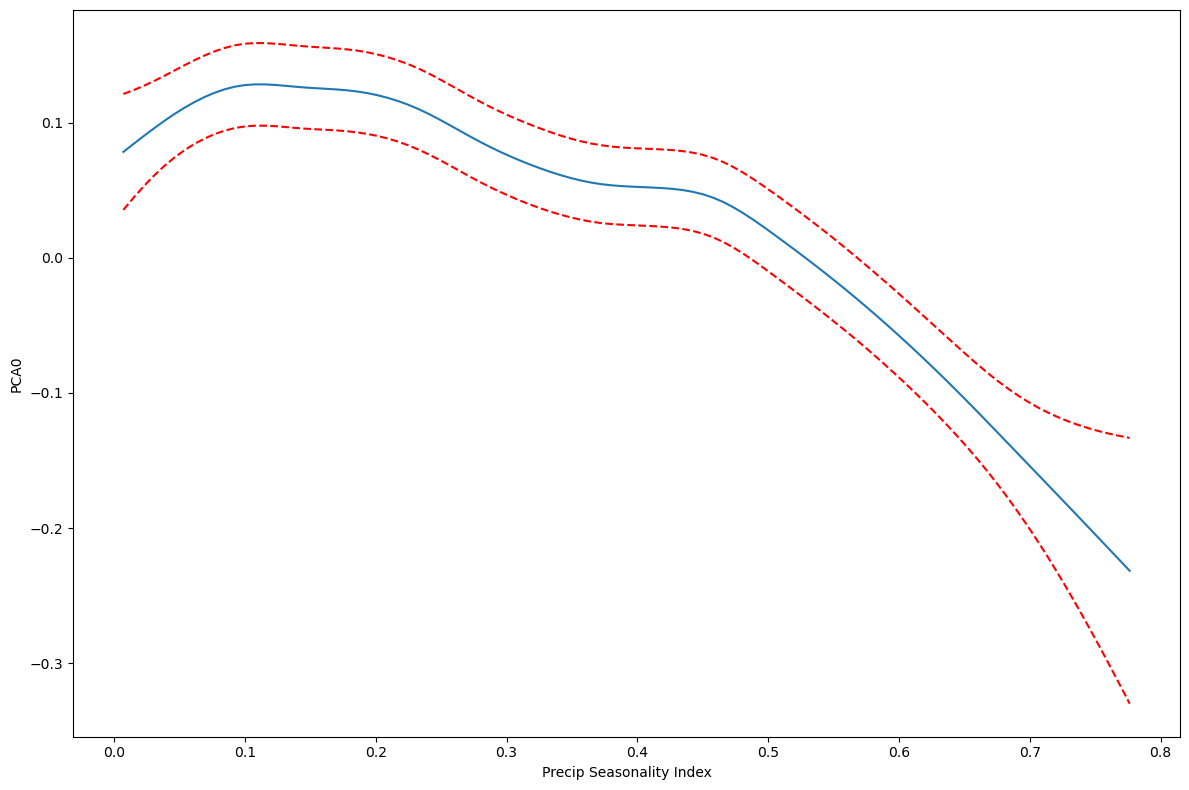

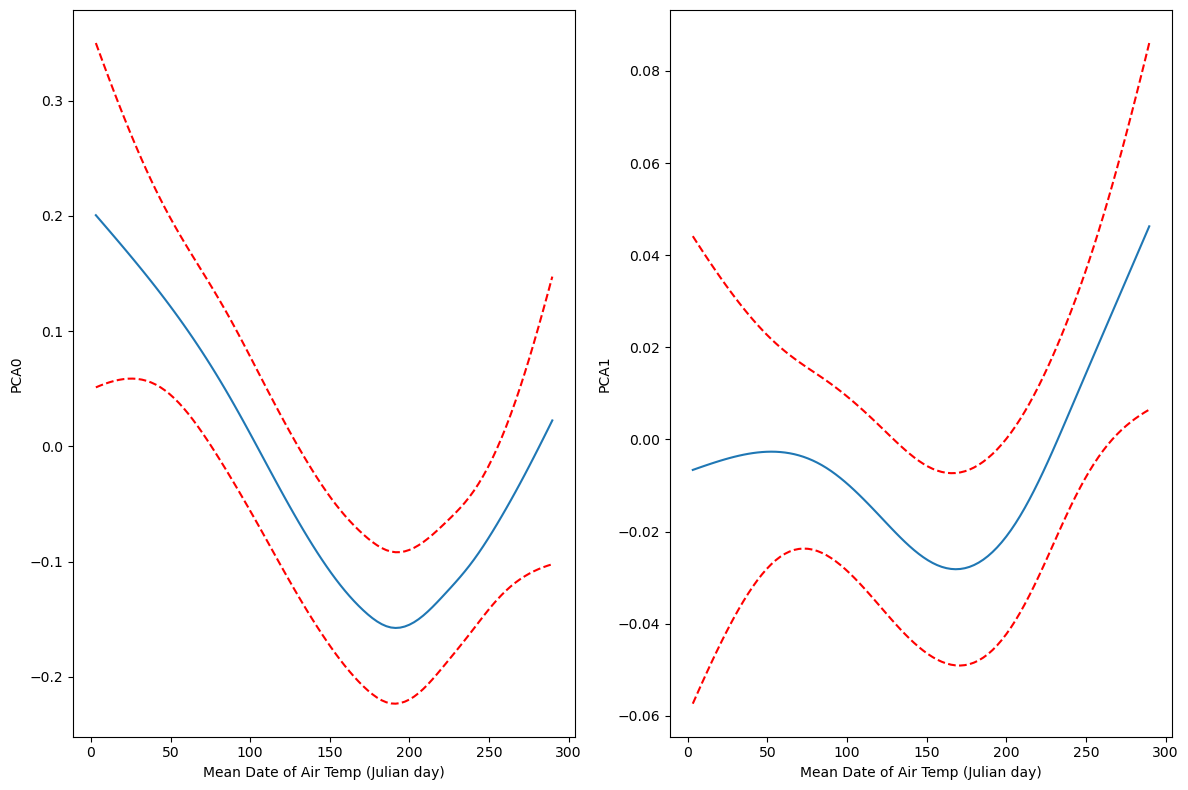

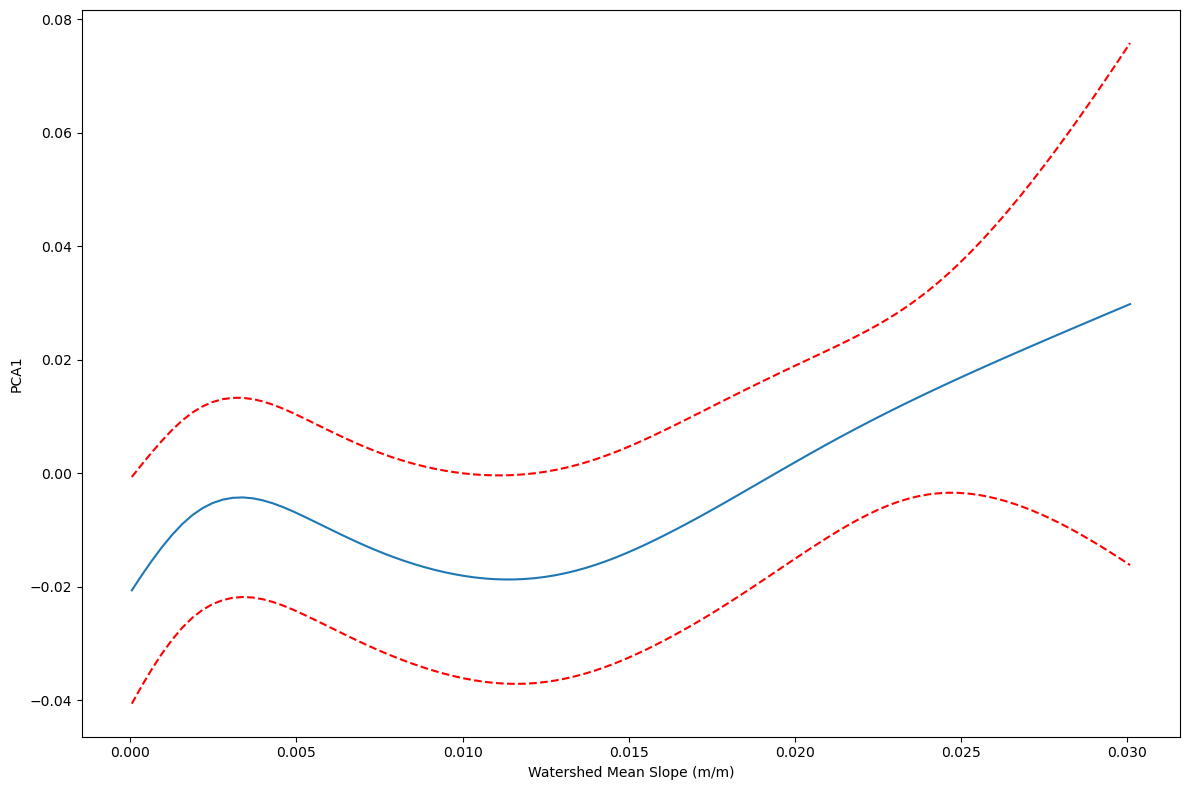

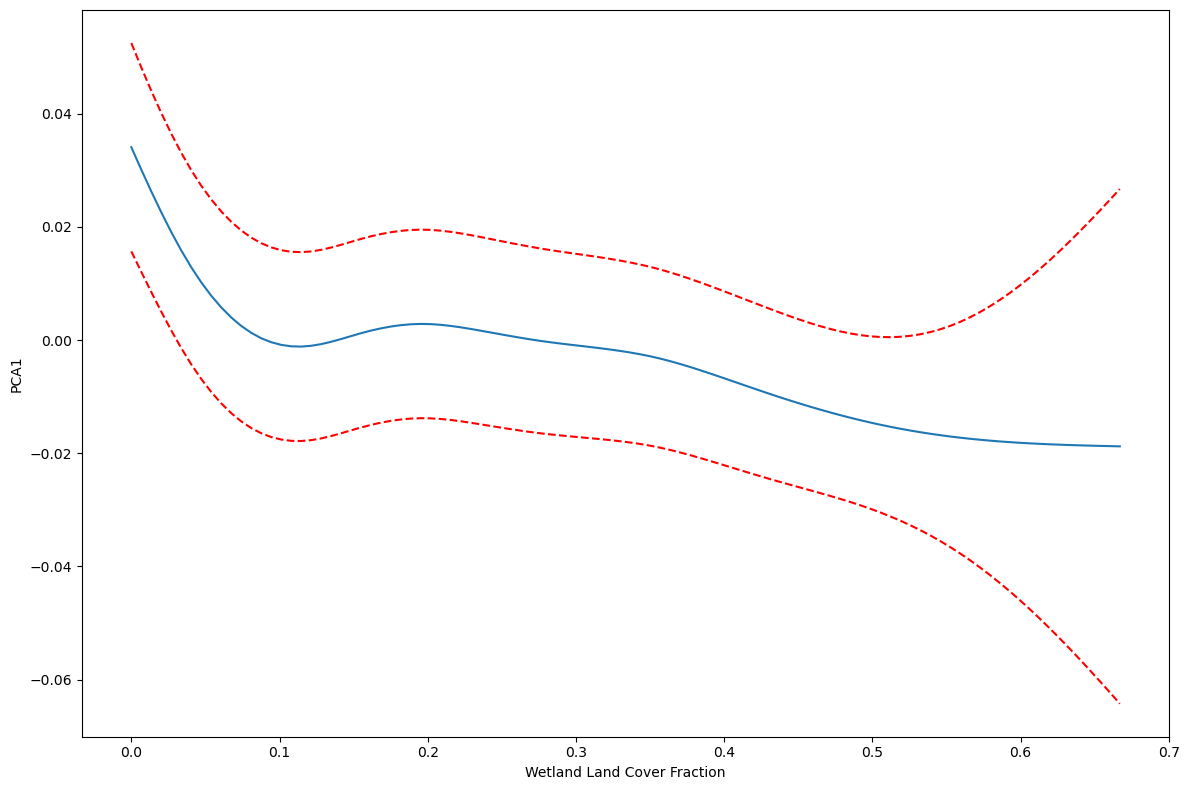

In [55]:
# (gam, xnames, simple_xnames, yname)
savebase = bp + "results/PCA_PDPs/PDPbyX_"
allgams = [
    (gam0, rename(var0), var0, "PCA0"),
    (gam1, rename(var1), var1, "PCA1"),
    # (gam2, rename(var2), var2, "PCA2"),
    # (gam3, rename(var3), var3, "PCA3"),
    # (gam4, rename(var4), var4, "PCA4"),
    # (gam5, rename(var5), var5, "PCA5"),
    # (gam6, rename(var6), var6, "PCA6"),
    # (gam7, rename(var7), var7, "PCA7"),
    # (gam8, rename(var8), var8, "PCA8")
]
pdps_by_x(allgams, savebase)

## Plot Reconstructed GAMs

In [56]:
savebase = bp + "results/PCA_PDPs/RxcPDPs_"
allgams = [
    (gam0, rename(var0), var0, 0),
    (gam1, rename(var1), var1, 1),
    # (gam2, rename(var2), var2, 2),
    # (gam3, rename(var3), var3, 3),
    # (gam4, rename(var4), var4, 4),
    # (gam5, rename(var5), var5, 5),
    # (gam6, rename(var6), var6, 6),
    # (gam7, rename(var7), var7, 7),
    # (gam8, rename(var8), var8, 8)
]
pca_pdps(allgams, savebase)

# Print GAMs

In [57]:
# Note: you can use this manually to make a "multi-interaction" by
# putting in all interacting variables and then separating the
# te()s.  If you do this, you have to run it once for each set and then
# combine the overlapping ones only.
def itx_rewrite(which, vrs):
    if which is None:
        return (vrs, eqmk(len(vrs)))
    relevant = all([w in vrs for w in which])
    if not relevant:
        return (vrs, eqmk(len(vrs)))
    # Now, we put the relevant variables at the end
    base = [v for v in vrs if not v in which]
    eq = eqmk(len(base)) + te(*range(len(base), len(vrs)))
    return (base + which, eq)

In [58]:
# Run this to build list...
print("var_sets = [")
# for (vr, nm) in [("itx", "Intercept"), ("amp", "Amplitude"), ("ssu", "SpringSummer"),
#                  ("fw", "FallWinter"), ("spd", "SpringDay"), ("sud", "SummerDay"),
#                  ("fad", "FallDay"), ("wid", "WinterDay"),
#                  # ("atc", "at_coef")
#                  ("tcmax", "threshold_coef_max"), ("tcmin", "threshold_coef_min"), ("tcc", "threshold_act_cutoff")
#                 ]:
for pca in range(9):
    vr = str(pca)
    nm = "PCA" + vr
    vrs = eval("var" + vr)
    eq = eval("eq" + vr)
    noise = eval("noise" + vr)
    (vrs, eq) = itx_rewrite(["canopy", "ws_canopy"], vrs)
    lam = eval("lam" + vr)
    print(f'    {{"name": "{nm}", "vars": {vrs}, "eq": {eq}, "lam": {lam:.0f}, "noise": {noise: .3f}}},')
    # print(f"var_{vr} = {eval('var_' + vr)}")
    # print(f"eq_{vr} = {eval('eq_' + vr)}")
    # print(f"lam_{vr} = {eval('lam_' + vr)}")
print("]")

var_sets = [
    {"name": "PCA0", "vars": ['tmax', 'vp', 'area', 'elev_min', 'developed', 'frozen', 'vp_sd', 'prcp_phi', 'prcp_index', 'tmax_phi', 'canopy', 'ws_canopy'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + te(10, 11), "lam": 10, "noise":  0.094},
    {"name": "PCA1", "vars": ['tmax', 'vp', 'area', 'elev_min', 'slope', 'wetland', 'ws_canopy', 'frozen', 'vp_sd', 'tmax_phi'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9), "lam": 30, "noise":  0.038},
    {"name": "PCA2", "vars": ['tmax', 'prcp', 'elev_min', 'slope', 'ice_snow', 'water', 'frozen', 'prcp_phi', 'prcp_index', 'tmax_phi'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9), "lam": 108, "noise":  0.004},
    {"name": "PCA3", "vars": ['tmax', 'vp', 'elev_min', 'wetland', 'water', 'frozen', 'cold_prcp', 'vp_sd', 'prcp_phi', 'prcp_index', 'canopy', 'ws_canopy'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + te(

# Cross-Validation Test

Right, we've got some approaches laid out.  Let's test it!  Export the GAM setups and hop over to the validation notebook.

Oddly, the "smart GAMs" are doing slightly worse than the "naive GAMs", though global R2 is much better.  Mainly, RMSE is marginally higher (2.3 vs 2.2 C median).  The plots show the usual mix of some near-perfect fits and some wildly off, with everything in between.

One possibility is that the relatively high lambdas, or likewise the aggressive paring-down, hinder cross-validation performance.  Performance characteristics shown suggest that the amplitude terms or the weather sensitivity may be faring poorly.  It's also possible that the intercept-normalizing of the amplitude coefficients was a net negative.

Allowing more flexibility helped but did not fully address the problem.  Likewise for non-normalizing.

I do wonder if the threshold behavior might be hurting rather than helping, since it seems rather hard to predict threshold coefficients.  The last resort would be that we really need the point-area data.

Excluding thresholds makes performance worse, though it does make the model ~3x faster.  The other last resort is to see what happens if we do include elevation.

Or, I may have been too aggressive about excluding covariates.

- Initial test: R2 0.94 (global 0.86), RMSE 2.3 (2.9) C, NSE 0.88 (0.86), bias 2.8% (2.0%) = 0.34 (0.26) C, max miss 3.0 (14.1) C
- More flexible: R2 0.94 (0.86), RMSE 2.3 (2.9) C, NSE 0.88 (0.86), bias 2.1% (2.0%) = 0.27 (0.27) C, max miss 2.9 (12.3) C
- Non-normalized: R2 0.94 (0.87), RMSE 2.3 (2.8) C, NSE 0.88, bias 2.5% (1.9%) = 0.35 (0.25) C, max miss 3.0 (12.2) C
- No threshold: R2 0.94 (0.87), RMSE 2.3 (2.8) C, NSE 0.88 (0.87), bias 2.6% (2.0%) = 0.35 (0.26) C, max miss 3.3 (12.3) C
- Smarter GAMs (with threshold): R2 0.94 (0.88), RMSE 2.1 (2.7) C, NSE 0.90 (0.88), bias 2.2% (2.0%) = 0.29 (0.26) C, max miss 3.0 (9.3) C

Now we're talking!  And the major problem does seem to be anomaly prediction, but this version is good enough for now.

The anomaly NSE is actually surprisingly good, at 0.50 (better than TE2, oddly), but, oddly, that's worse than stationary ("same as yesterday").  In TempEst 2, stationary NSE was ~0.2.  Not sure what happened there.  Though, of course, for ungaged watersheds we don't *have* an observation for yesterday, so it's still an improvement and considerably better than climatology (NSE = 0).